In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw8.ipynb")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# CPSC 330 - Applied Machine Learning

## Homework 8: Introduction to Computer vision and Time Series (Lectures 19 and 20) 

**Due date: see the [Calendar](https://htmlpreview.github.io/?https://github.com/UBC-CS/cpsc330/blob/master/docs/calendar.html).**

## Imports

In [2]:
from hashlib import sha1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

<div class="alert alert-info">
    
## Submission instructions
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2023W1/blob/main/docs/homework_instructions.md). 

**You may work in a group on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).


When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission.
4. Make sure that the plots and output are rendered properly in your submitted file. 
5. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb.

<br><br>

## Exercise 1: time series prediction

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset and storing it under the `data` folder. We will be forcasting average avocado price for the next week. 

In [3]:
df = pd.read_csv("data/avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

Date  AveragePrice  Total Volume     4046       4225    4770  \
0 2015-12-27          1.33      64236.62  1036.74   54454.85   48.16   
1 2015-12-20          1.35      54876.98   674.28   44638.81   58.33   
2 2015-12-13          0.93     118220.22   794.70  109149.67  130.50   
3 2015-12-06          1.08      78992.15  1132.00   71976.41   72.58   
4 2015-11-29          1.28      51039.60   941.48   43838.39   75.78   

   Total Bags  Small Bags  Large Bags  XLarge Bags          type  year  region  
0     8696.87     8603.62       93.25          0.0  conventional  2015  Albany  
1     9505.56     9408.07       97.49          0.0  conventional  2015  Albany  
2     8145.35     8042.21      103.14          0.0  conventional  2015  Albany  
3     5811.16     5677.40      133.76          0.0  conventional  2015  Albany  
4     6183.95     5986.26      197.69          0.0  conventional  2015  Albany

In [4]:
df.shape

(18249, 13)

In [5]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [6]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~2 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [7]:
split_date = '20170925'
df_train = df[df["Date"] <= split_date]
df_test  = df[df["Date"] >  split_date]

In [8]:
assert len(df_train) + len(df_test) == len(df)

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many time series? 
rubric={points:4}

In the [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) dataset from lecture demo, we had different measurements for each Location. 

We want you to consider this for the avocado prices dataset. For which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 4

In the avocado prices dataset, the categorical feature for which we have separate measurements is the "region". This is because the dataset records the avocado prices for different regions, as seen in the "region" column. Each row corresponds to data for a specific region, such as "Albany," and the price and volume measurements are reported for that region individually.

Thus, the "region" column acts as a categorical feature that divides the dataset into separate measurements based on location. Each region would have its own time series of avocado prices and related data.

Region: Albany
   AveragePrice       Date
0          1.33 2015-12-27
1          1.35 2015-12-20
2          0.93 2015-12-13
3          1.08 2015-12-06
4          1.28 2015-11-29
----------------------------------------
Region: Atlanta
   AveragePrice       Date
0          0.99 2015-12-27
1          1.08 2015-12-20
2          0.96 2015-12-13
3          1.07 2015-12-06
4          0.99 2015-11-29
----------------------------------------
Region: BaltimoreWashington
   AveragePrice       Date
0          1.17 2015-12-27
1          1.11 2015-12-20
2          1.15 2015-12-13
3          1.04 2015-12-06
4          1.16 2015-11-29
----------------------------------------
Region: Boise
   AveragePrice       Date
0          0.97 2015-12-27
1          1.03 2015-12-20
2          0.99 2015-12-13
3          0.71 2015-12-06
4          1.06 2015-11-29
----------------------------------------
Region: Boston
   AveragePrice       Date
0          1.13 2015-12-27
1          1.07 2015-12-20
2          1.01 201

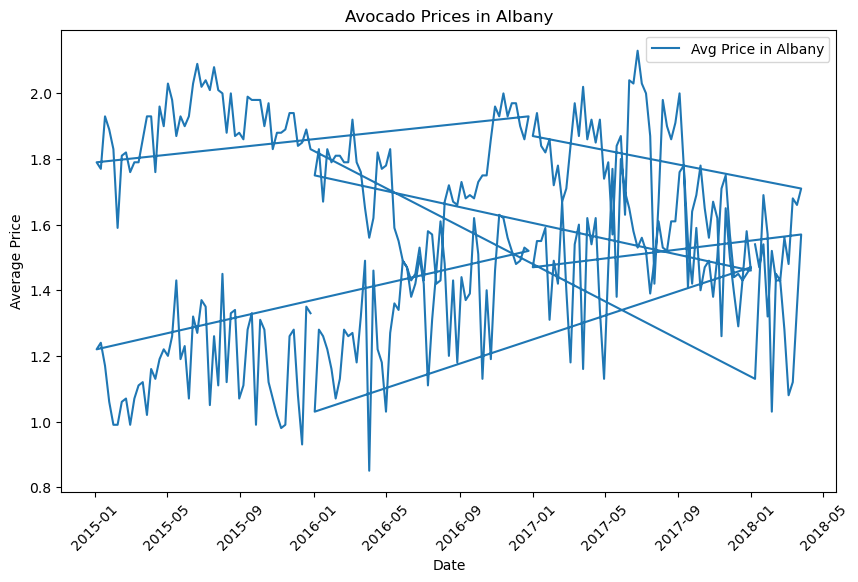

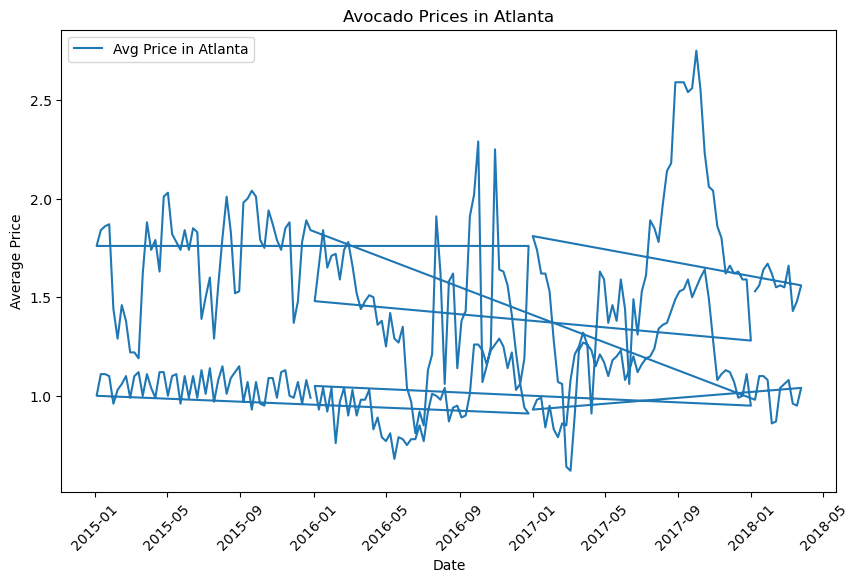

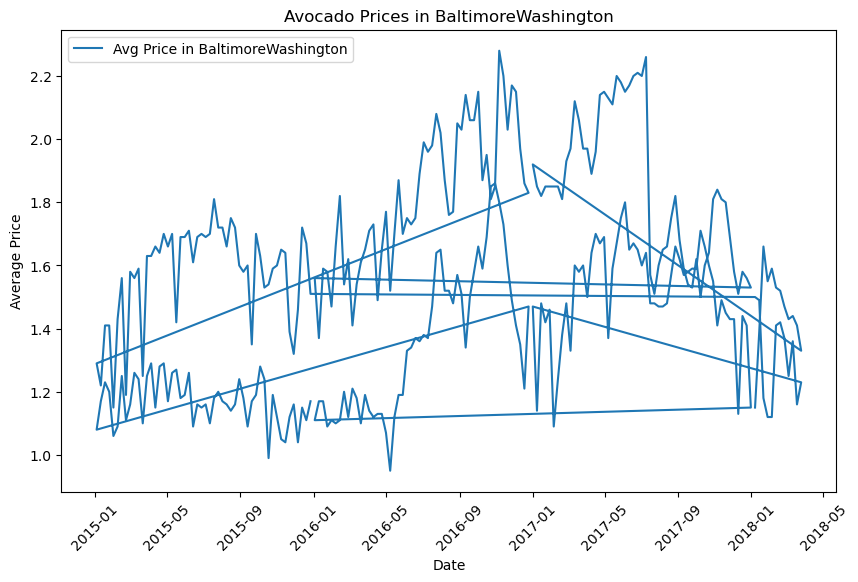

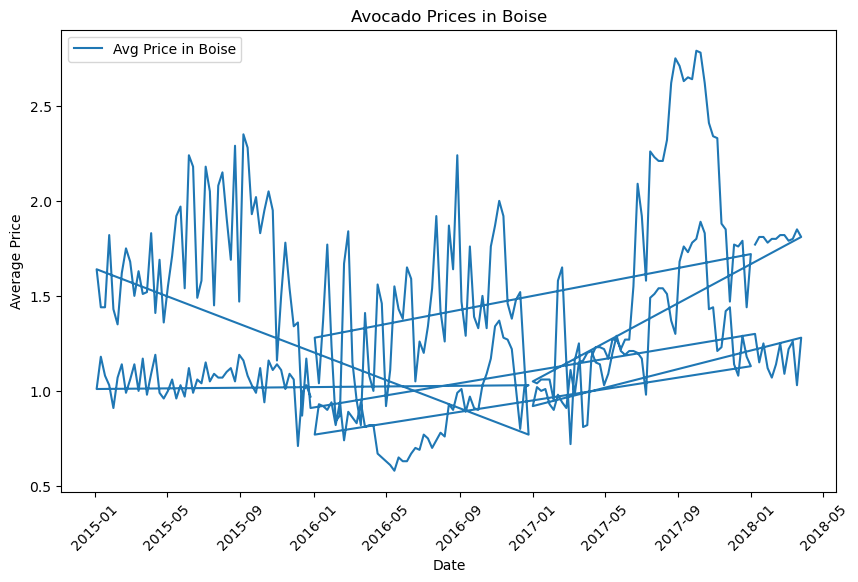

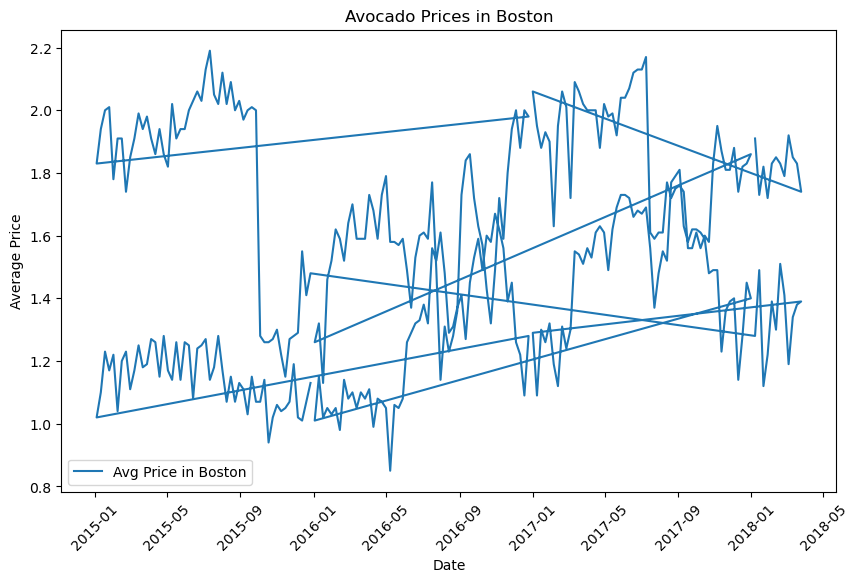

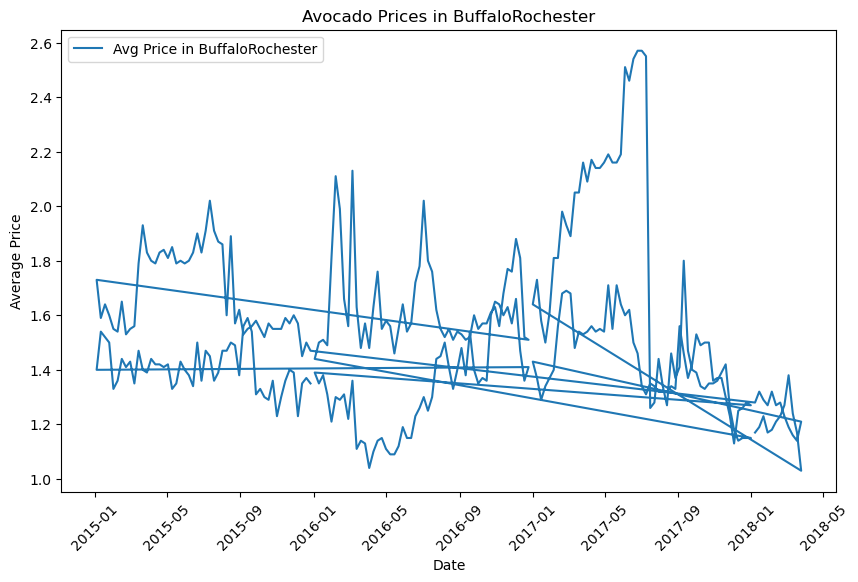

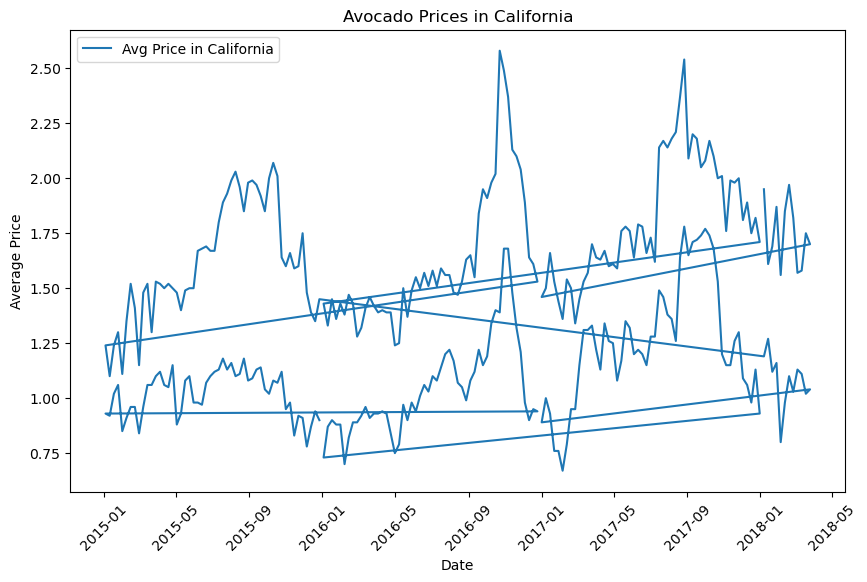

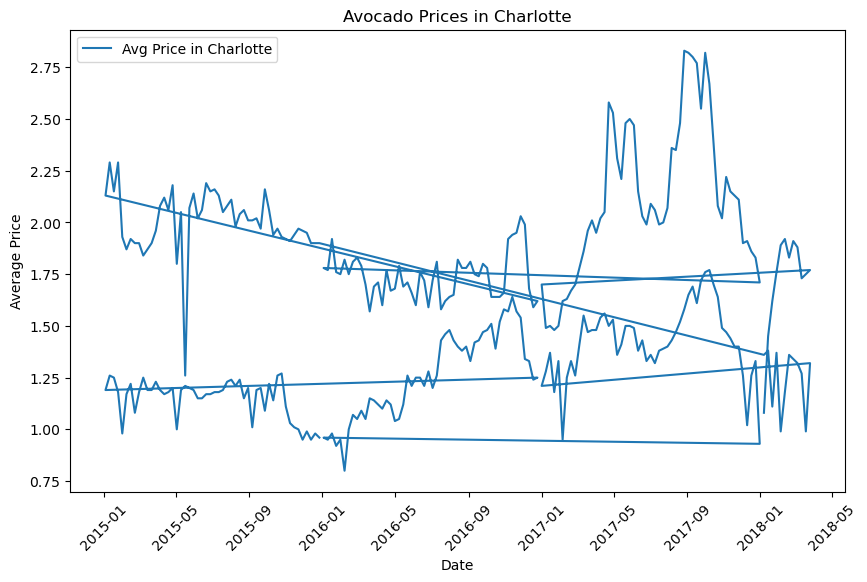

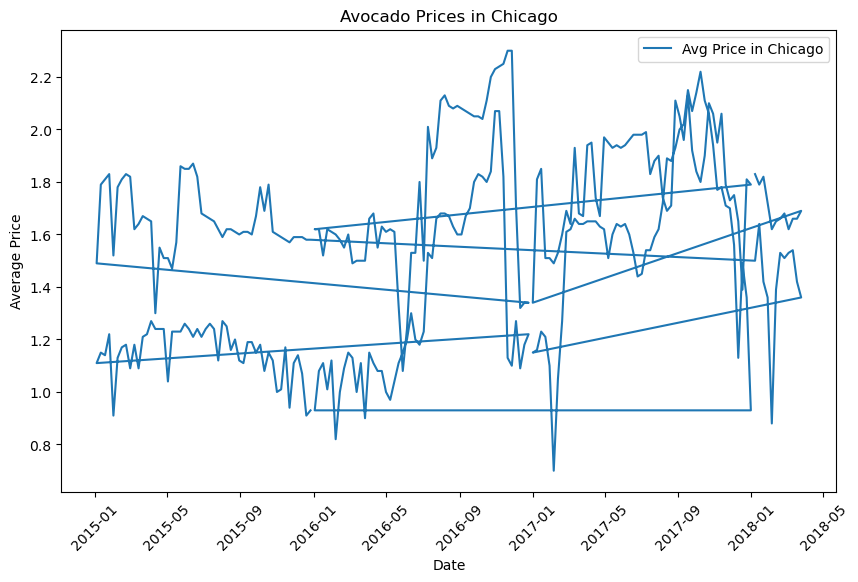

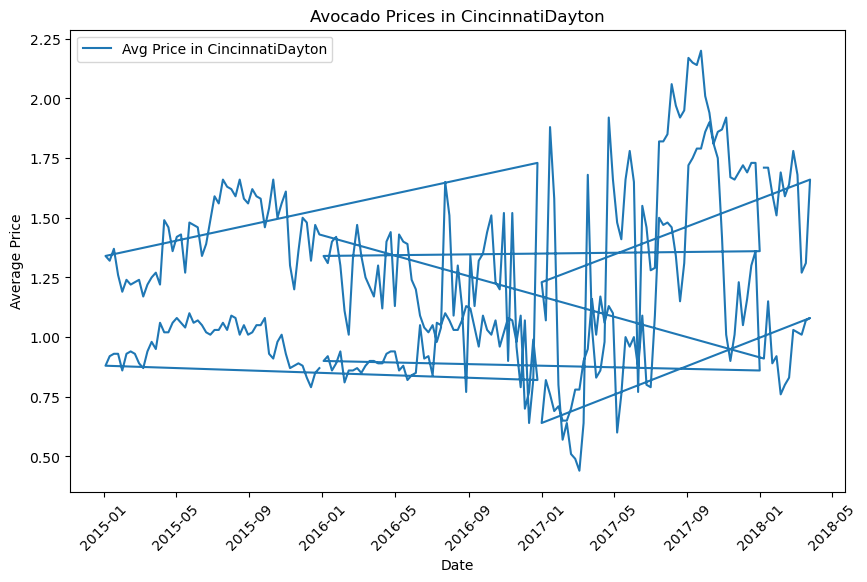

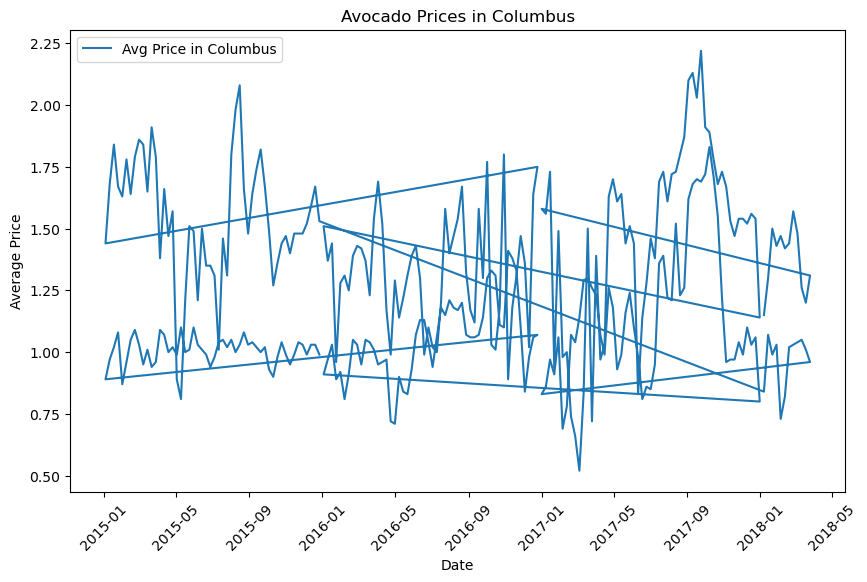

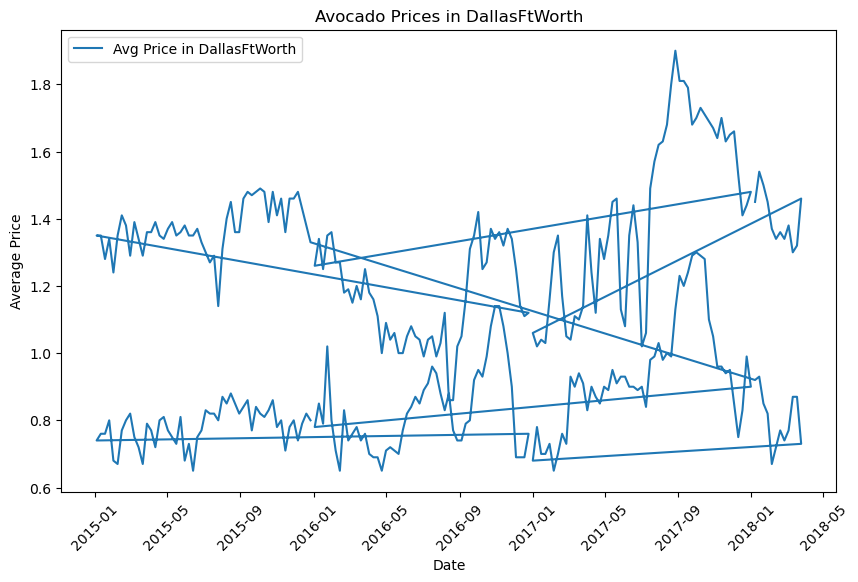

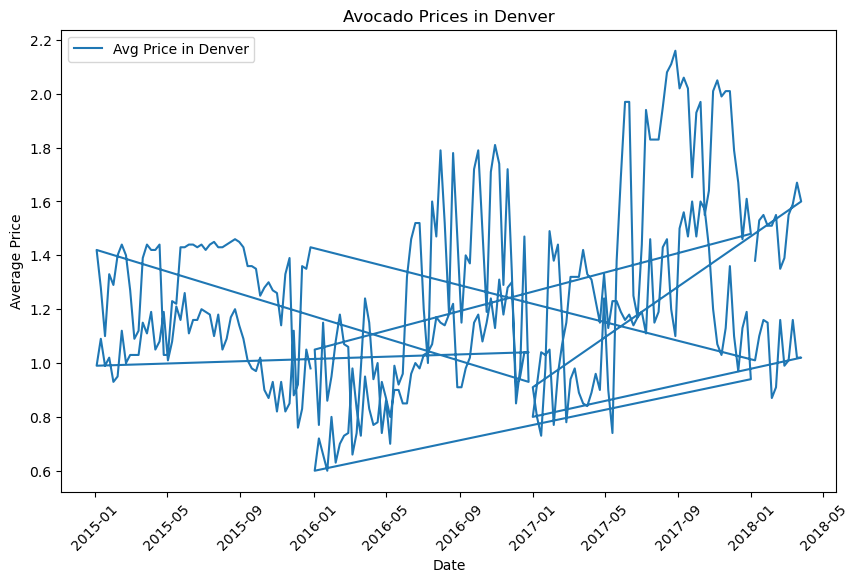

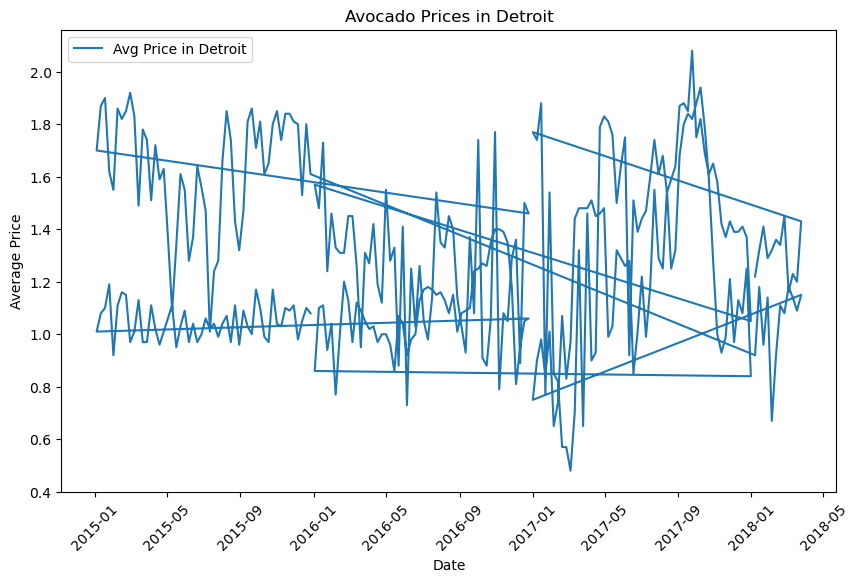

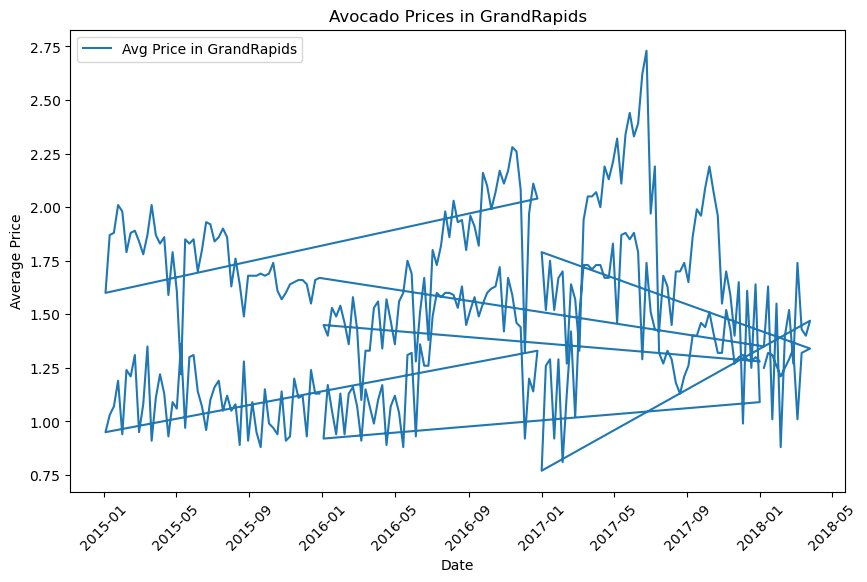

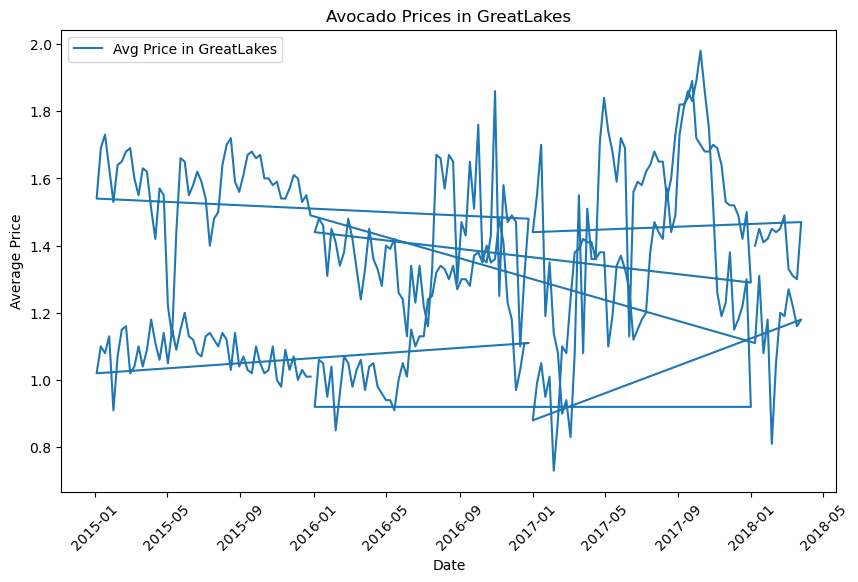

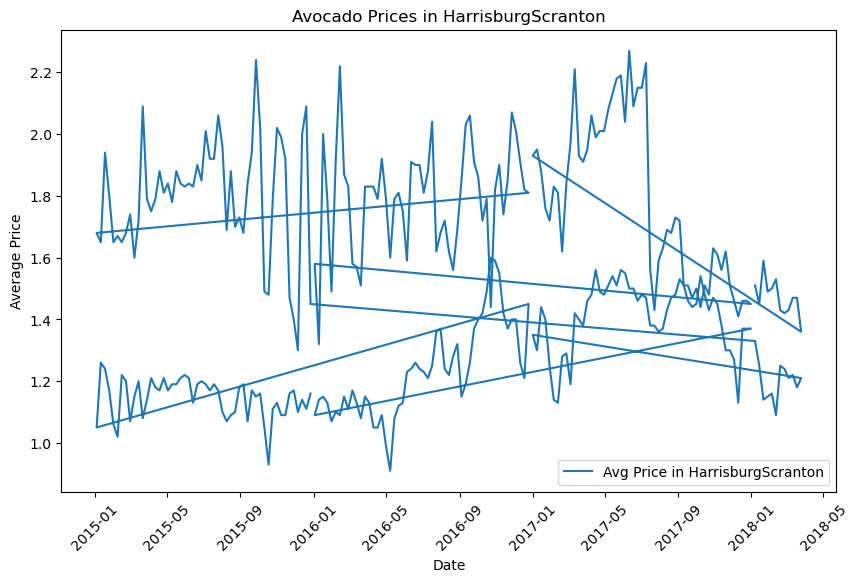

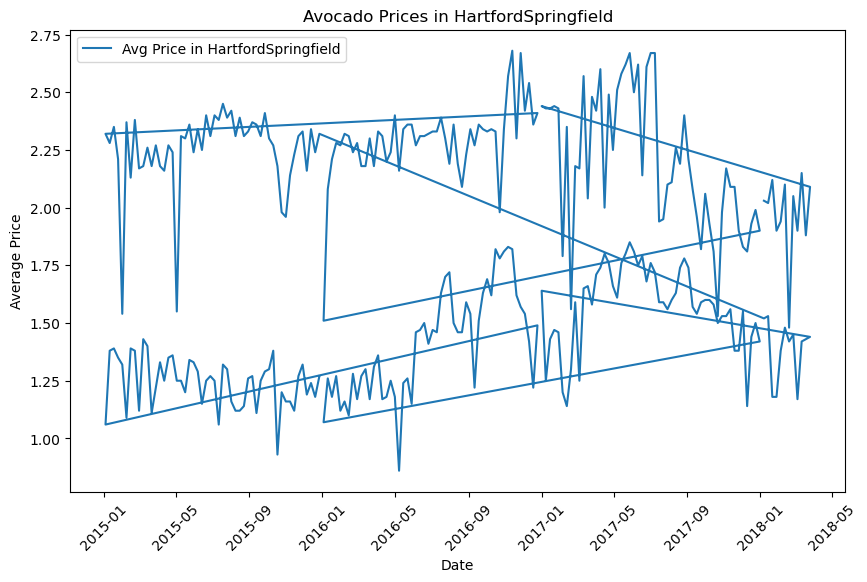

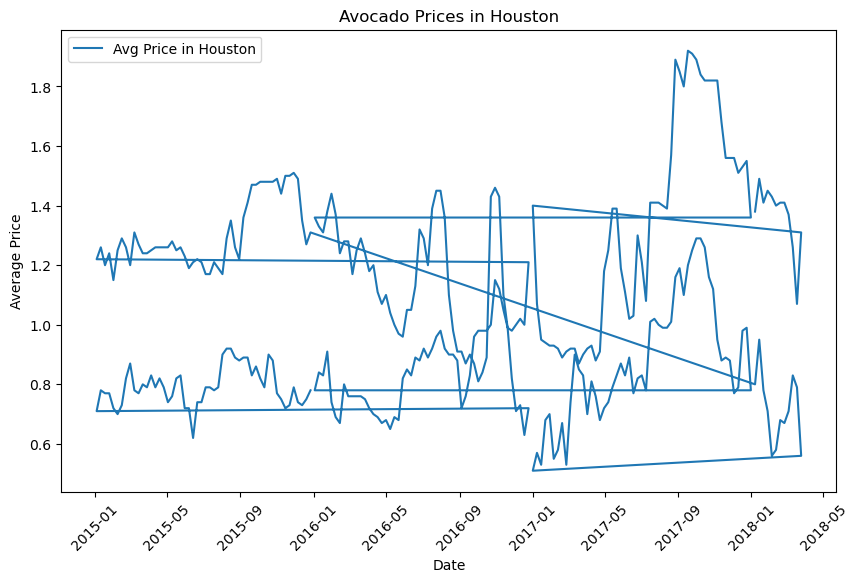

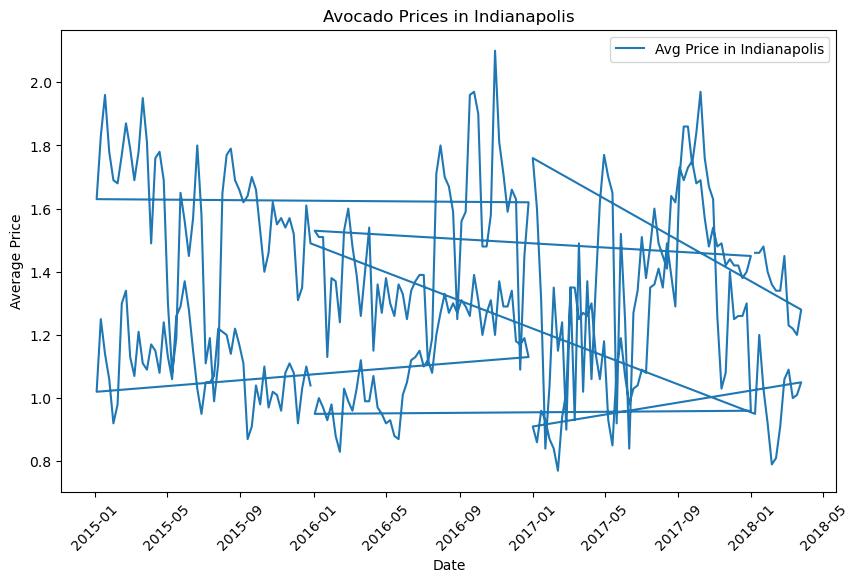

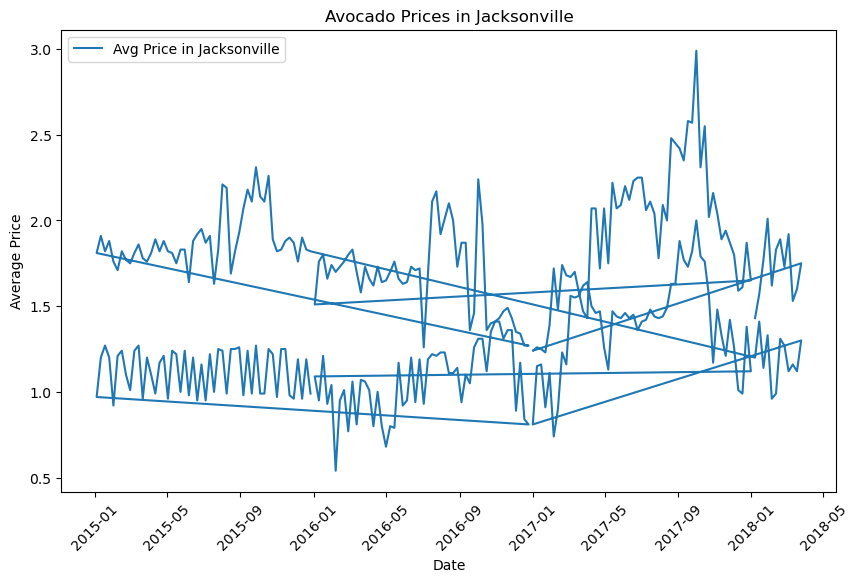

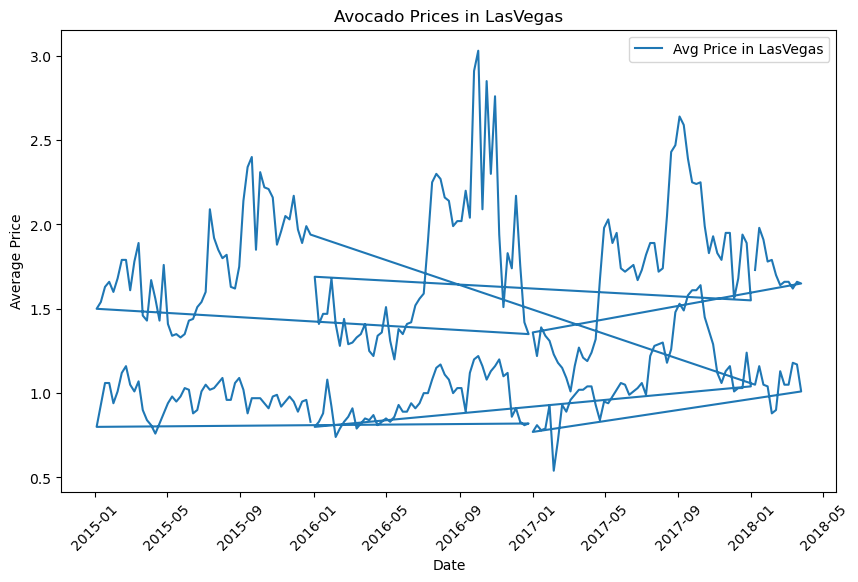

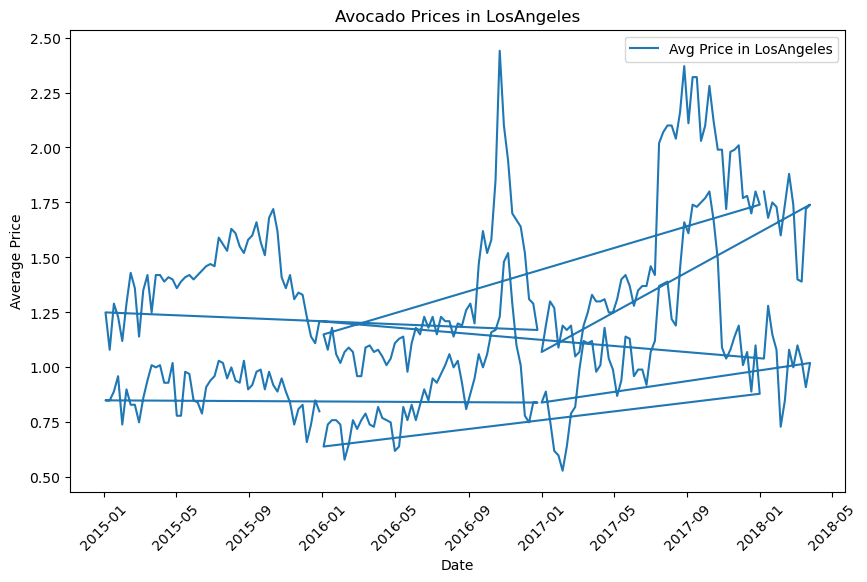

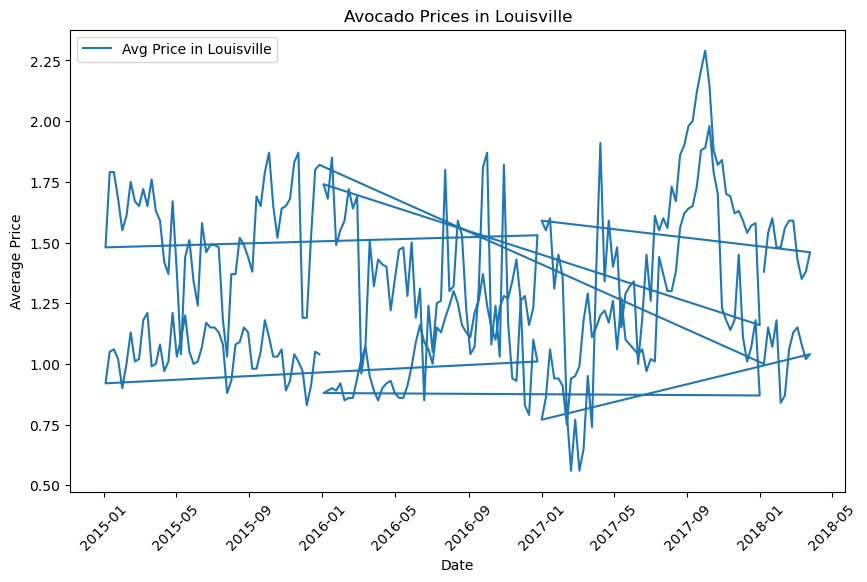

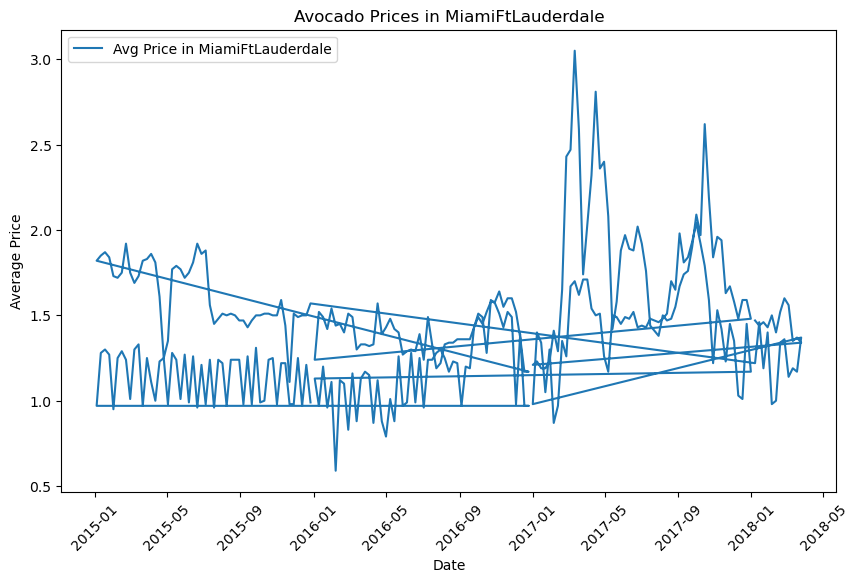

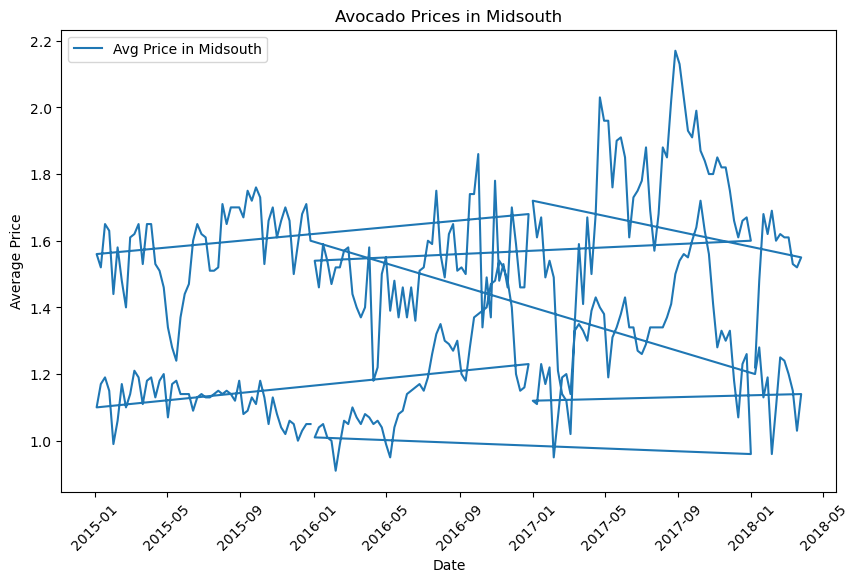

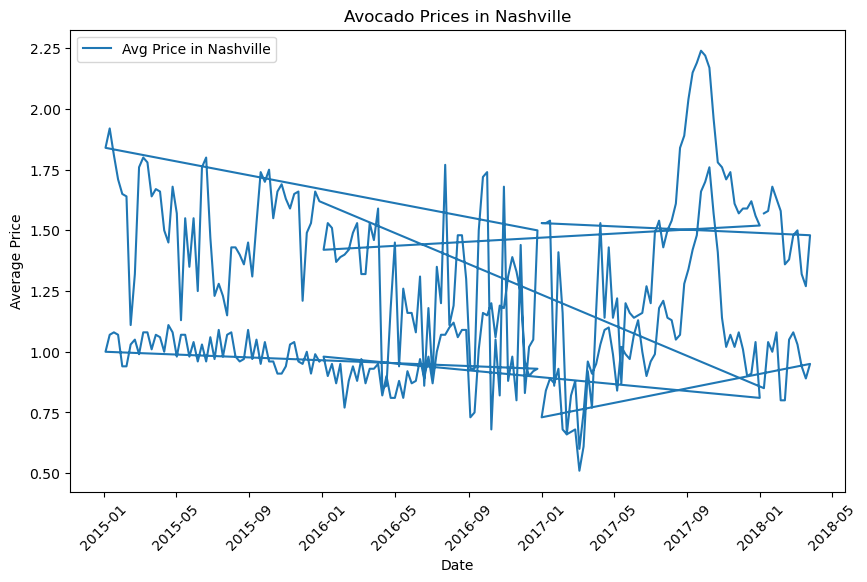

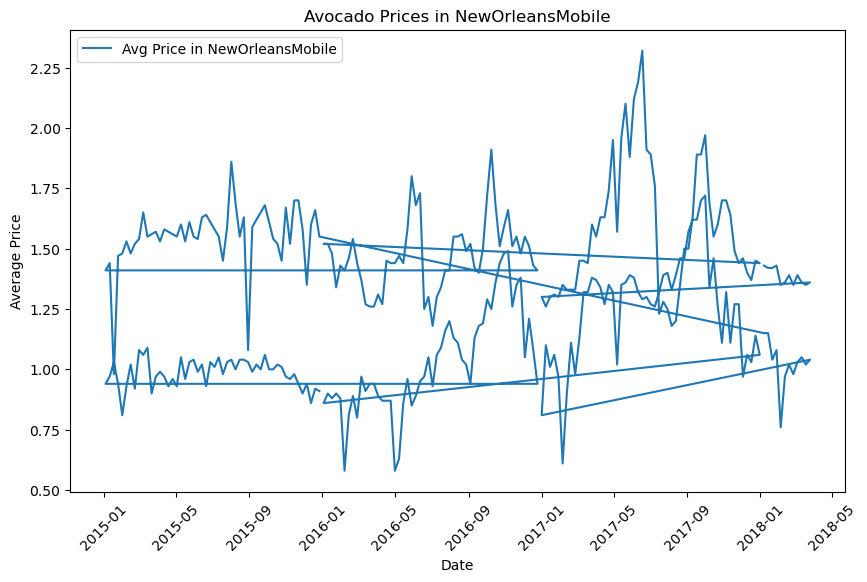

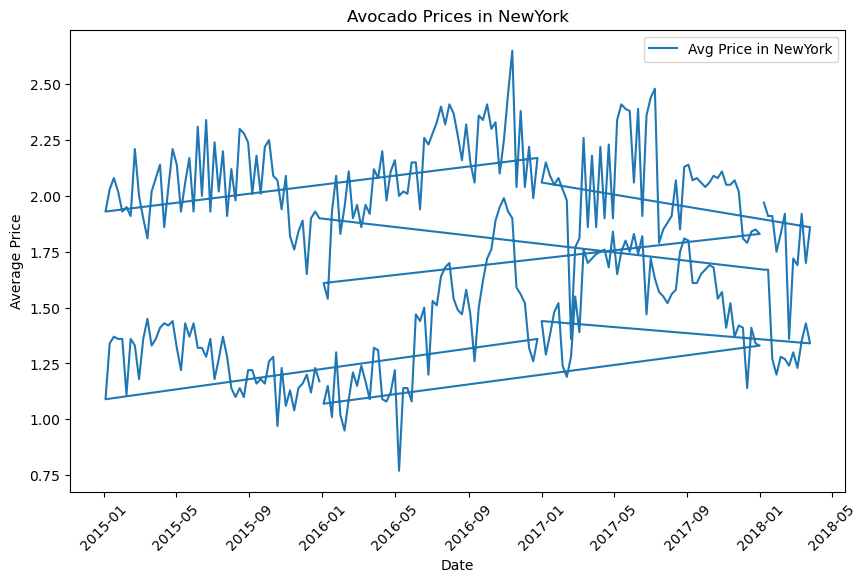

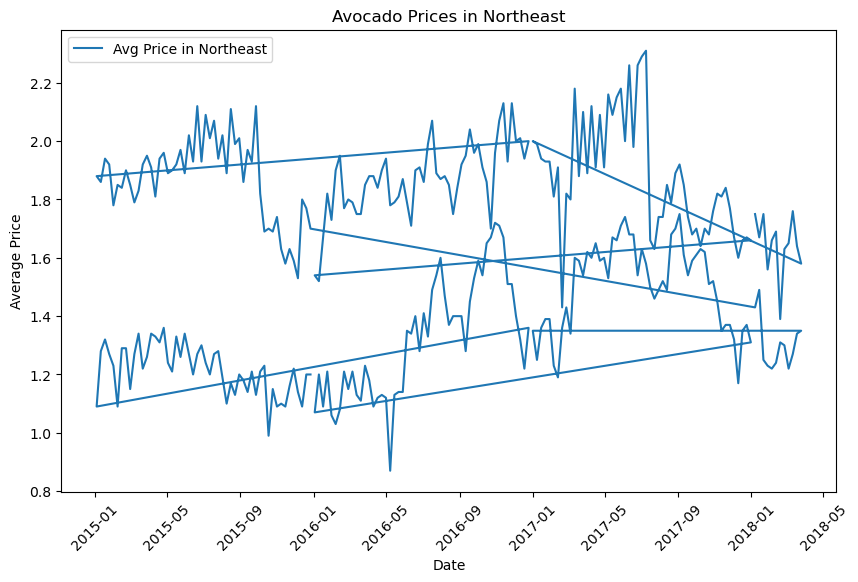

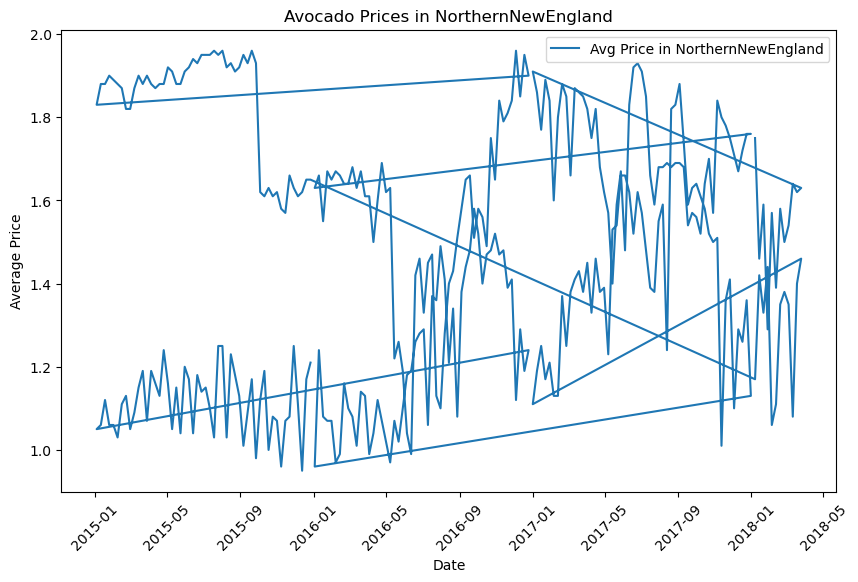

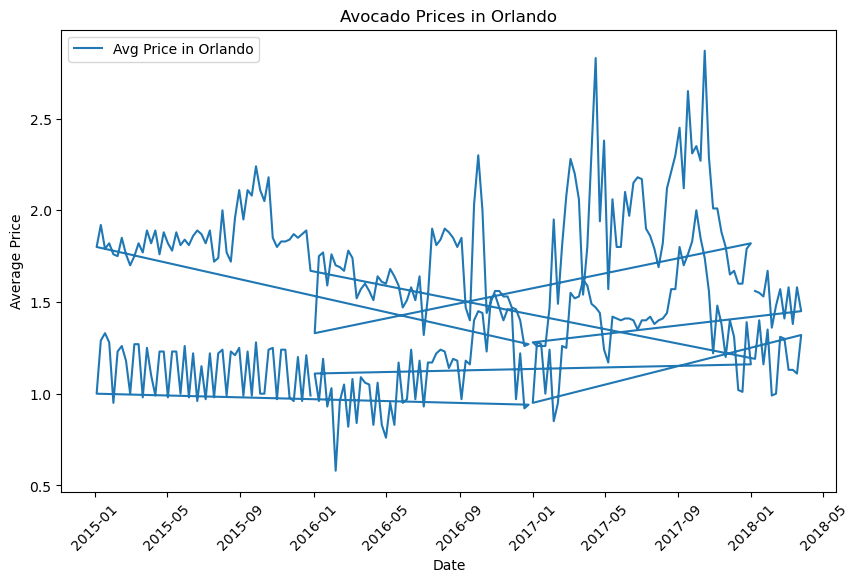

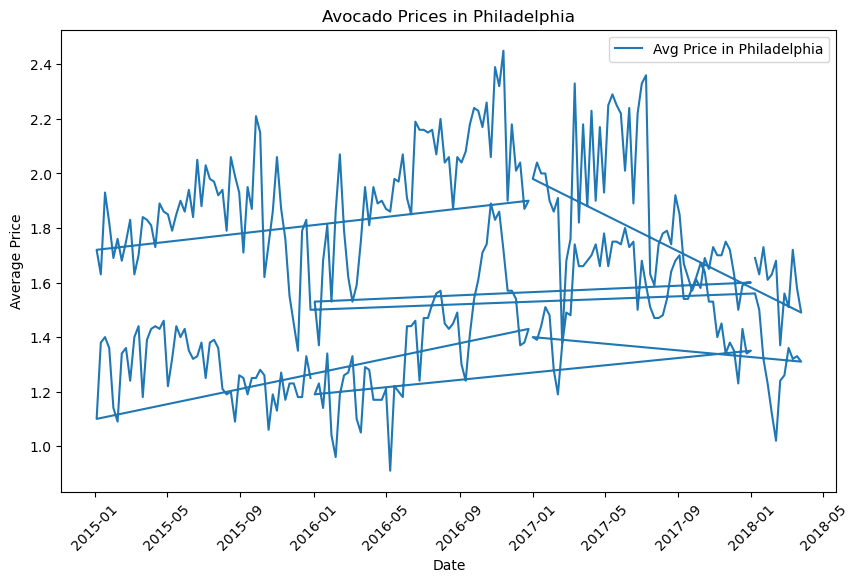

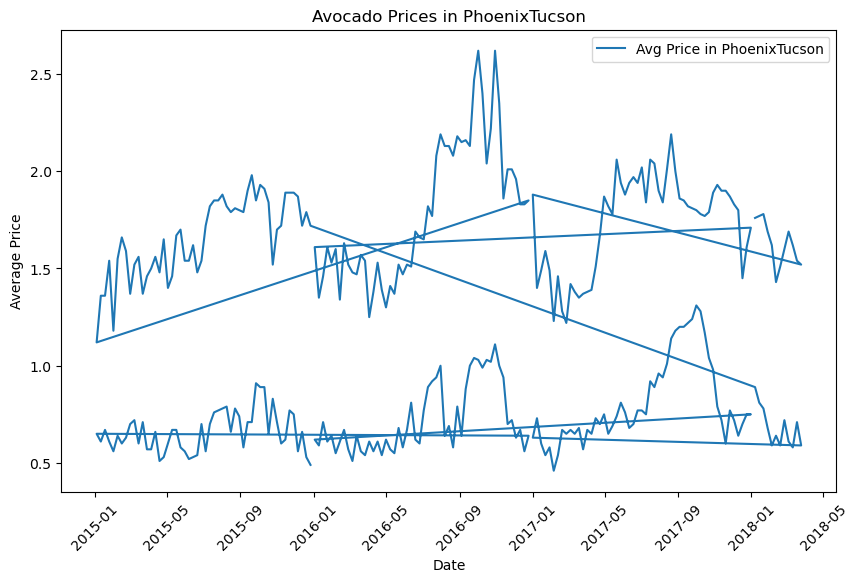

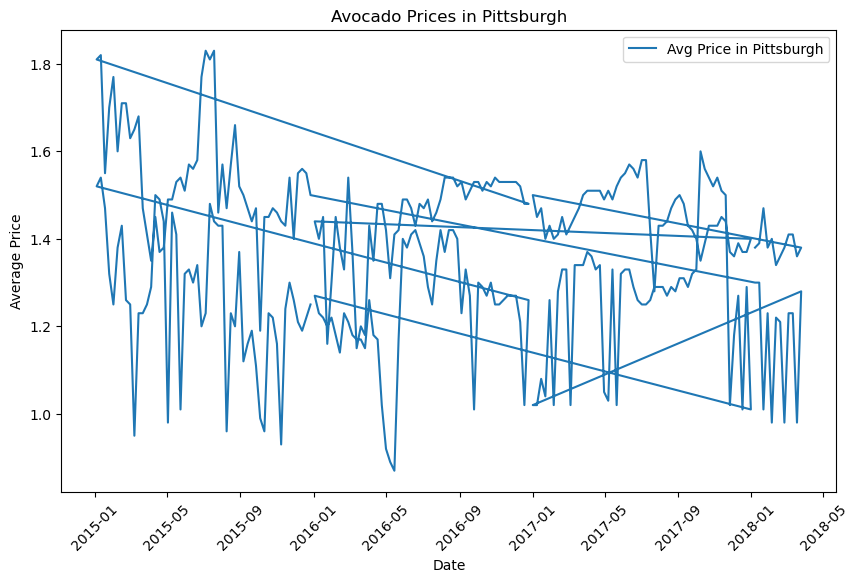

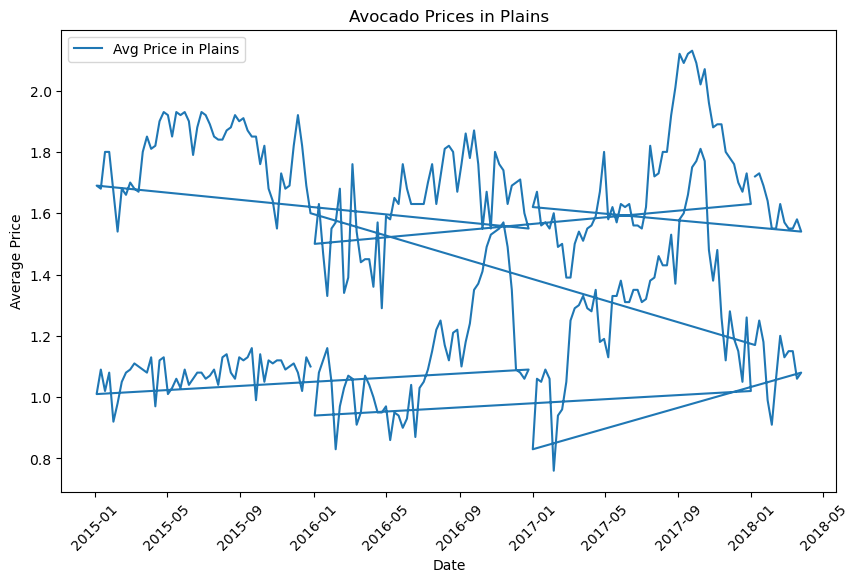

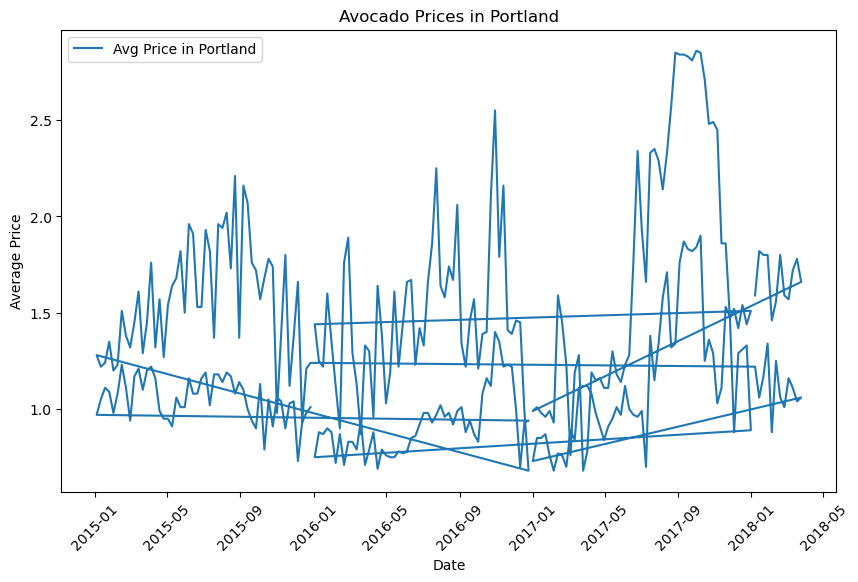

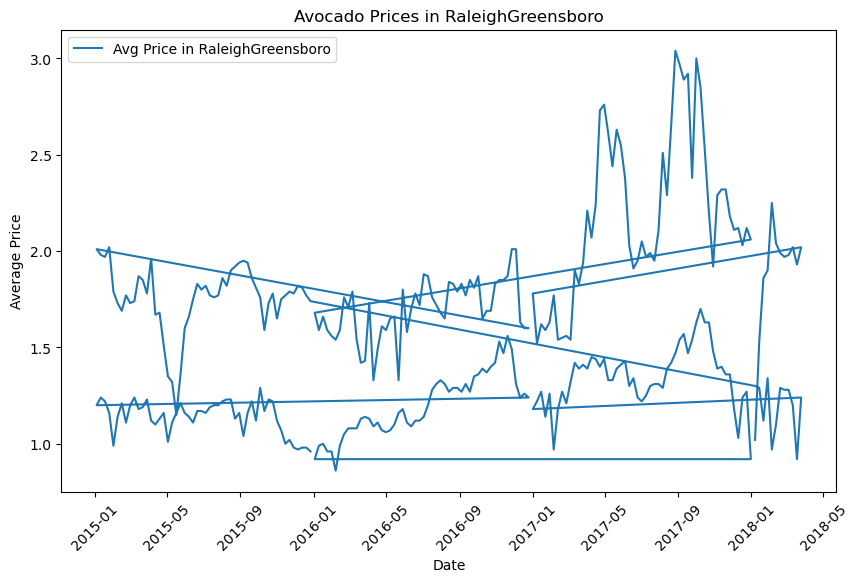

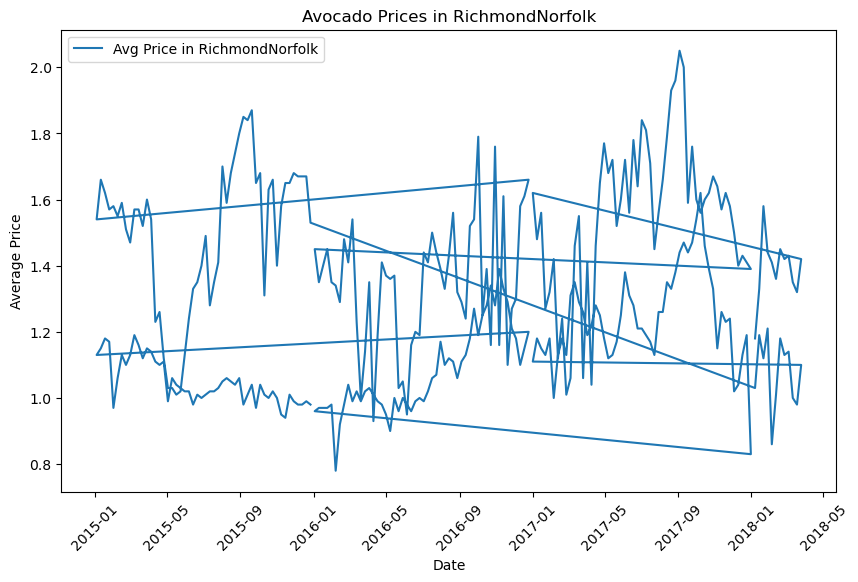

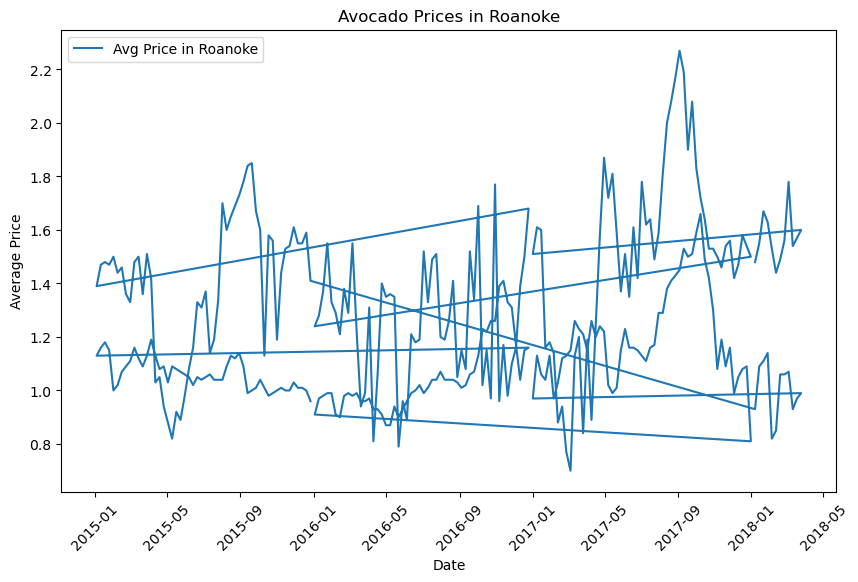

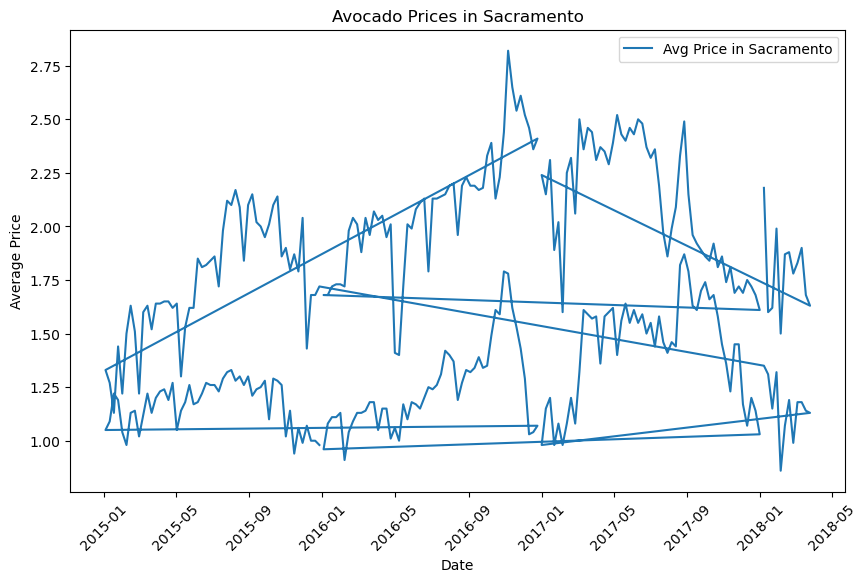

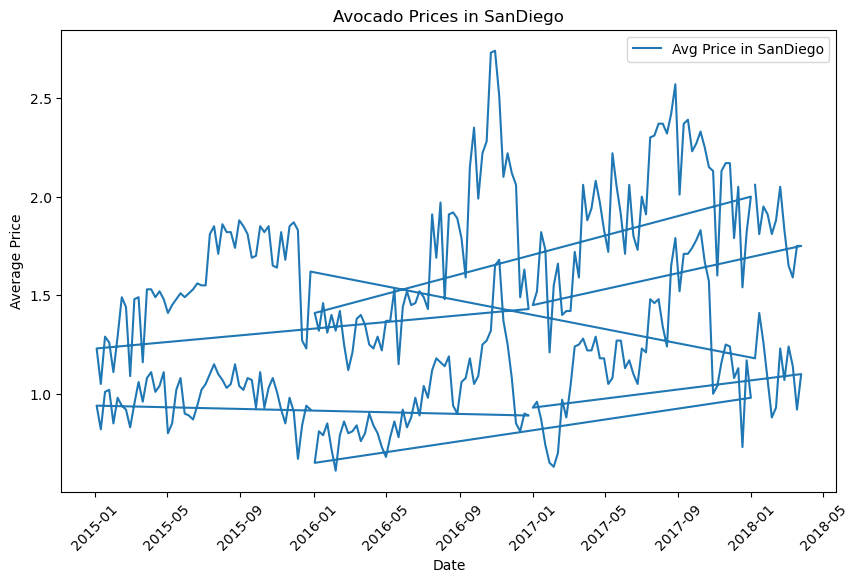

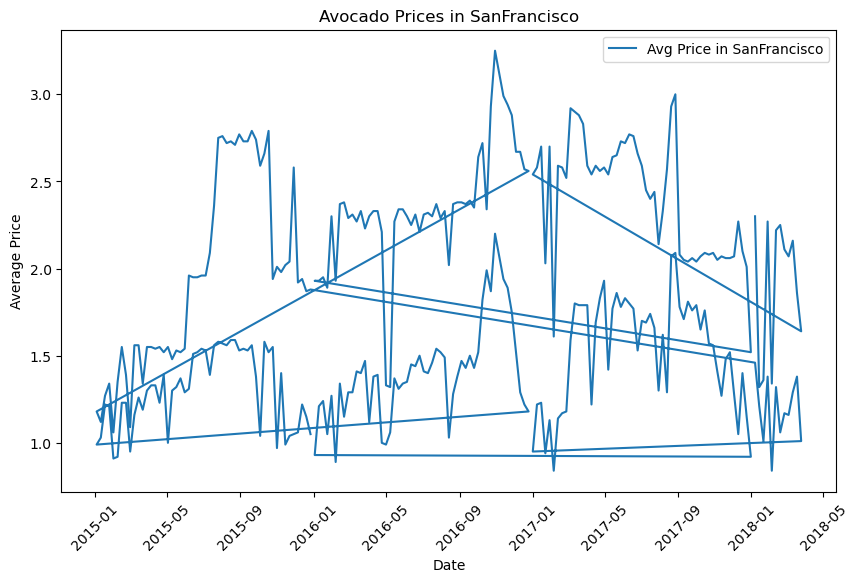

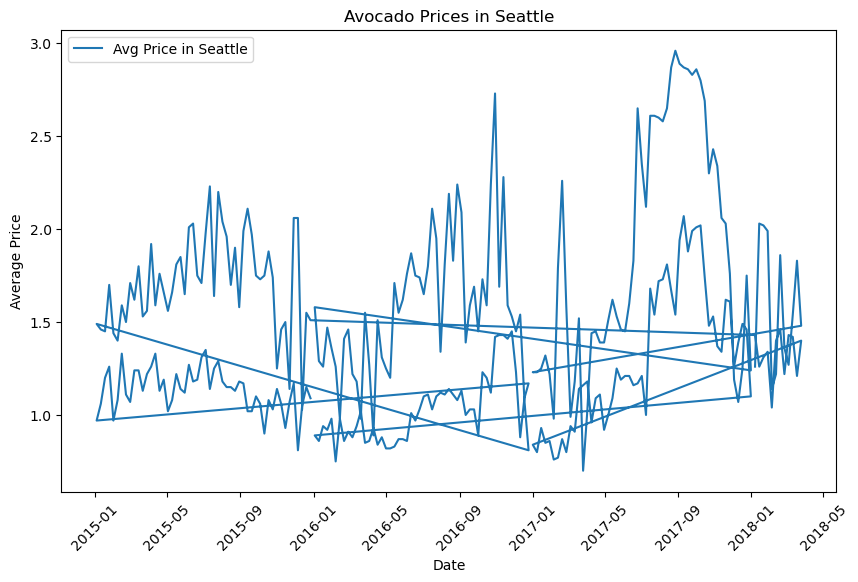

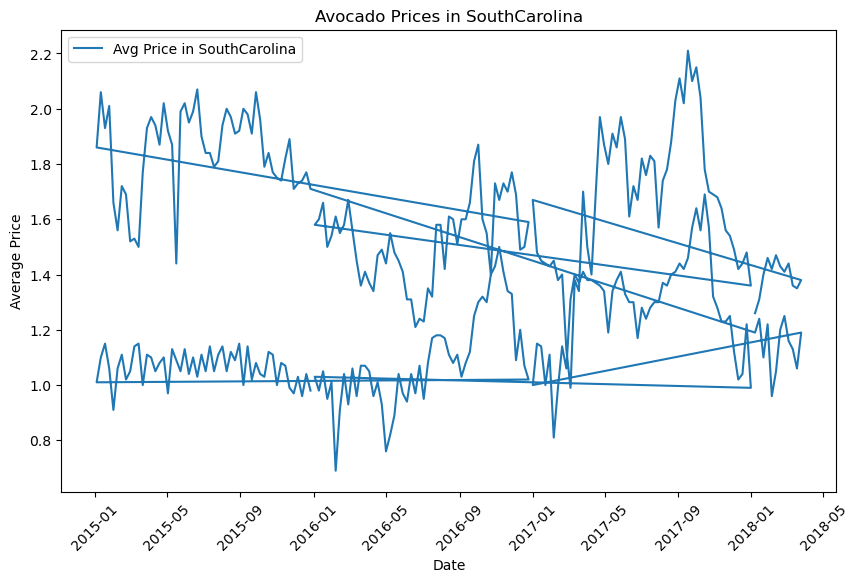

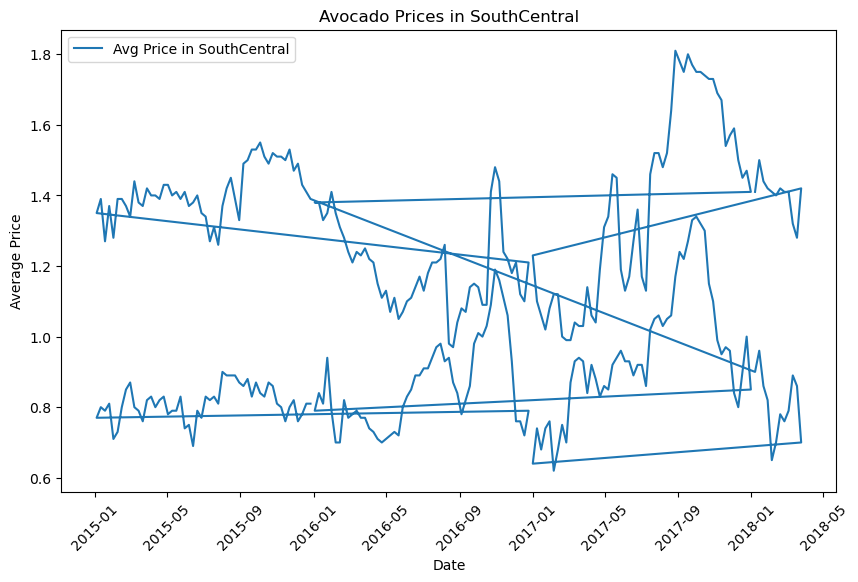

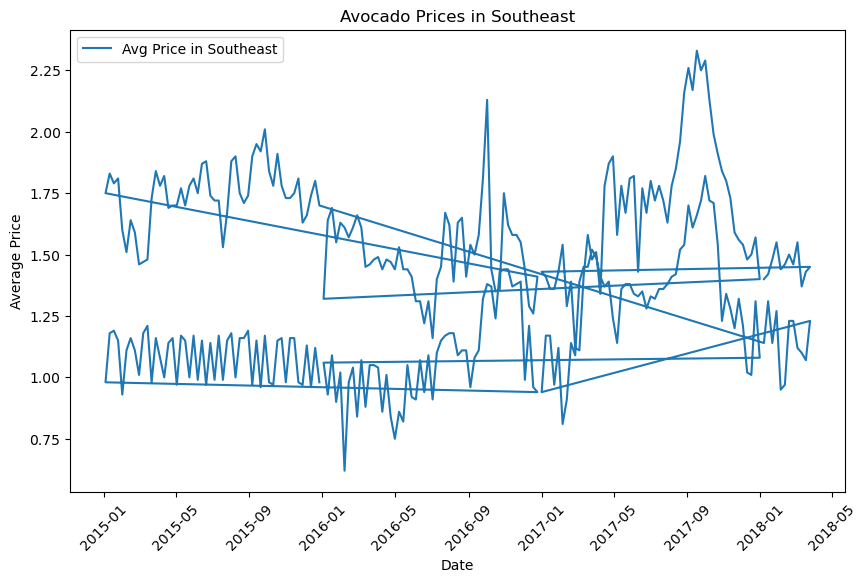

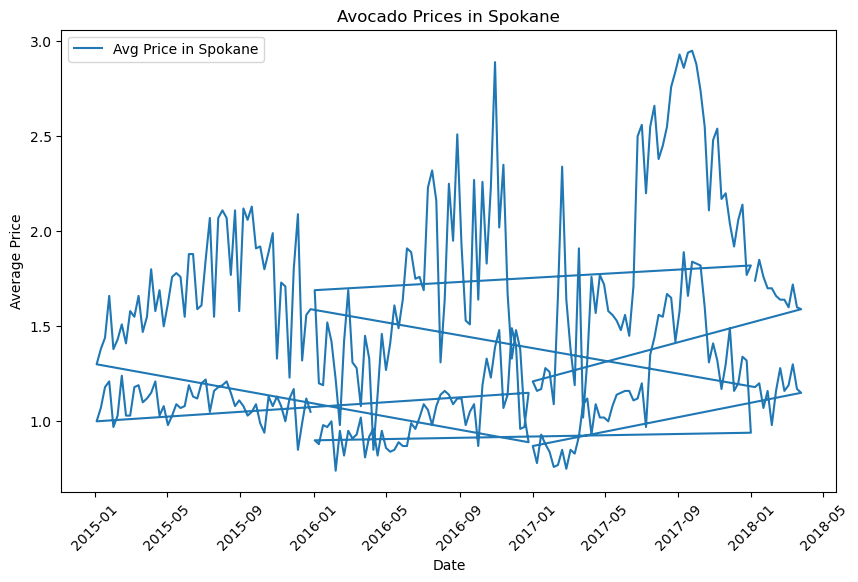

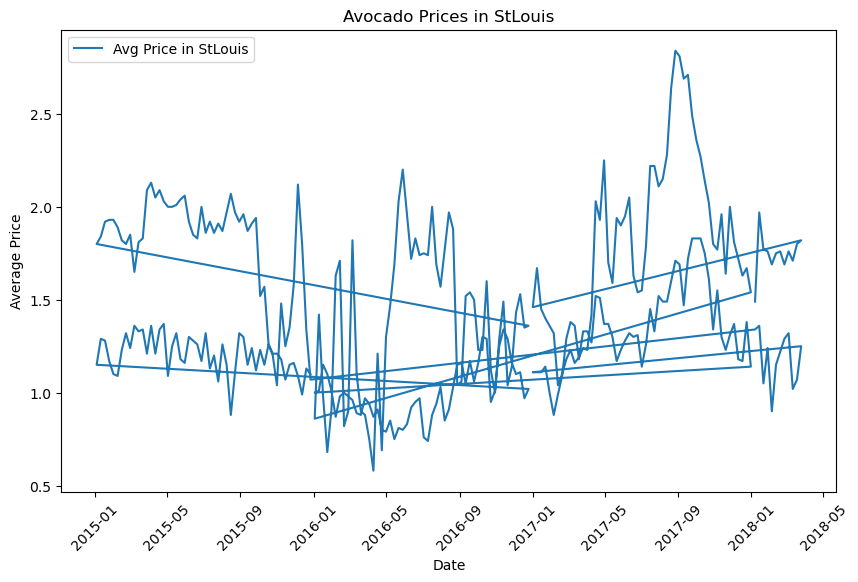

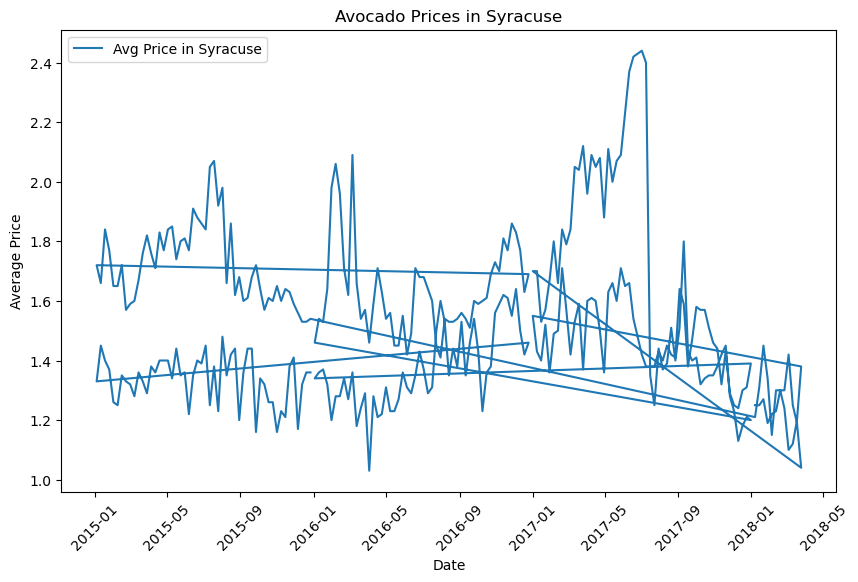

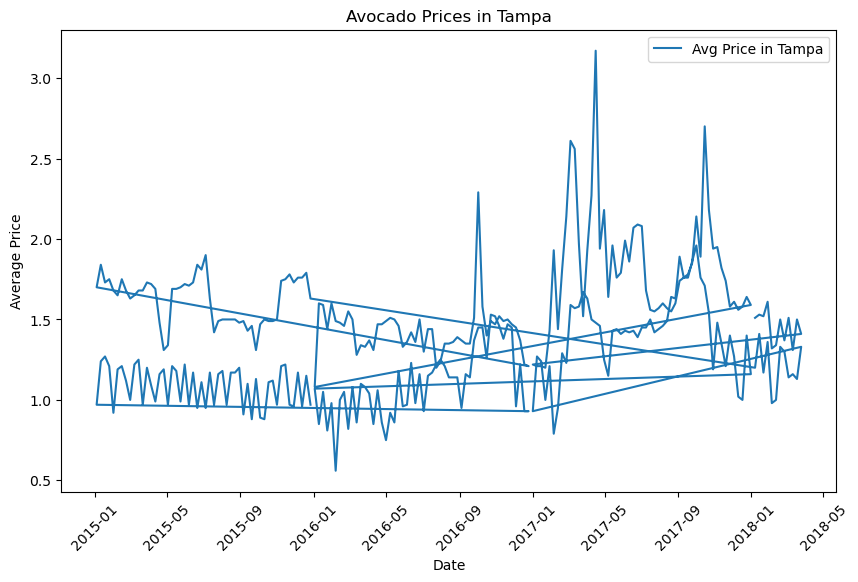

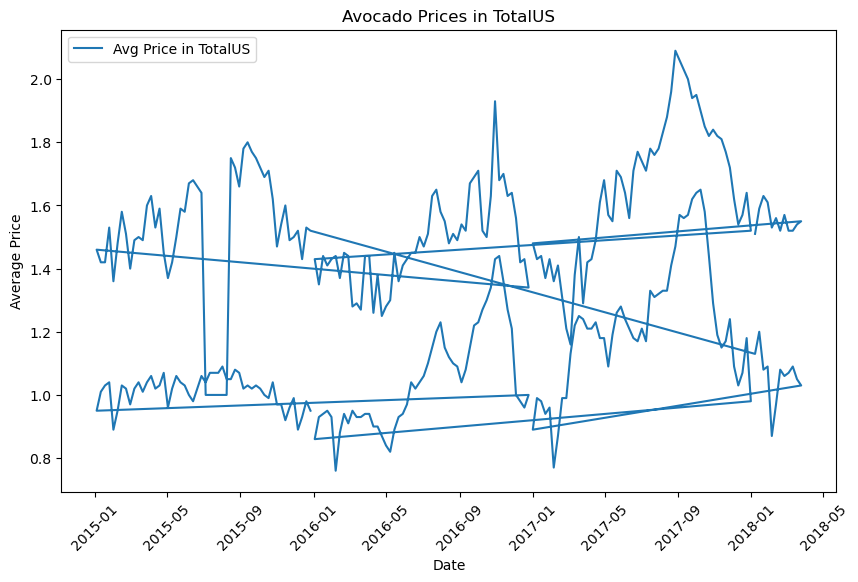

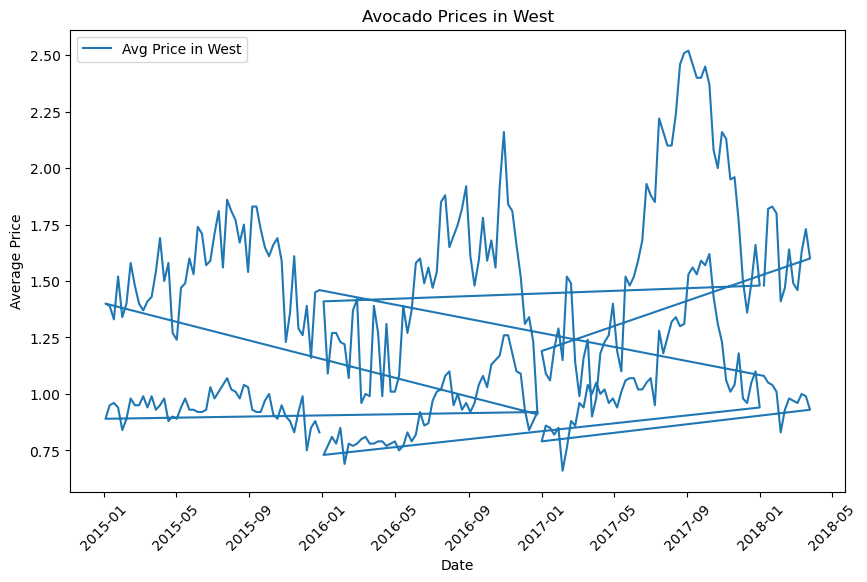

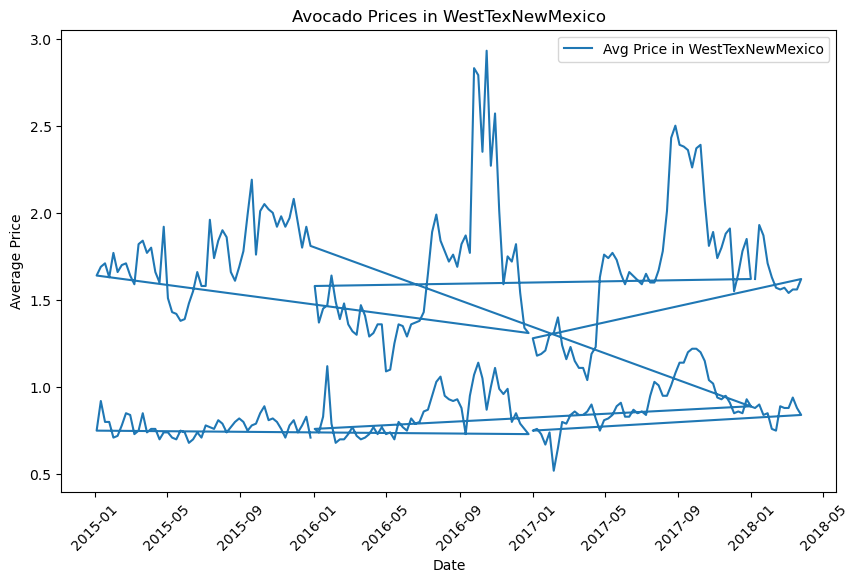

In [9]:
grouped_by_region = df.groupby('region')

for region, data in grouped_by_region:
    print(f"Region: {region}")
    print(data[['AveragePrice', 'Date']].head())
    print("-" * 40)

import matplotlib.pyplot as plt
for region, data in grouped_by_region:
    plt.figure(figsize=(10, 6))
    plt.plot(data['Date'], data['AveragePrice'], label=f"Avg Price in {region}")
    plt.title(f"Avocado Prices in {region}")
    plt.xlabel('Date')
    plt.ylabel('Average Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

In [10]:
...

Ellipsis

In [11]:
...

Ellipsis

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.2 Equally spaced measurements? 
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 4

There are 169 instances where the consecutive data points are from the same date (i.e., multiple entries per day).
There are 168 instances where consecutive data points are exactly 7 days apart (which likely indicates weekly measurements).
This shows that the dataset has a combination of same-day measurements (0 days) and weekly measurements (7 days apart).



Time spacing counts for SanDiego:
Date
0 days    169
7 days    168
Name: count, dtype: int64



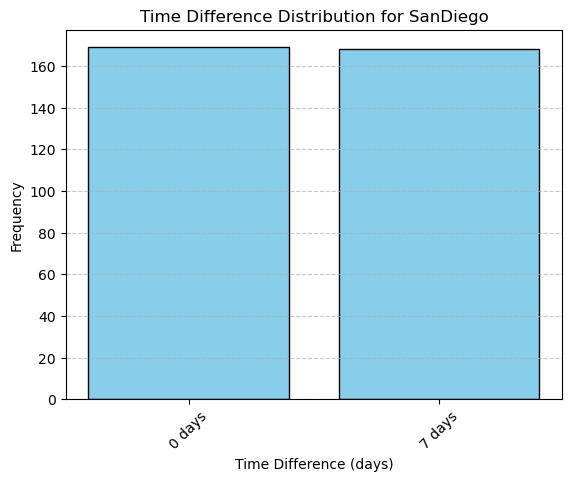

Time spacing counts for Spokane:
Date
0 days    169
7 days    168
Name: count, dtype: int64



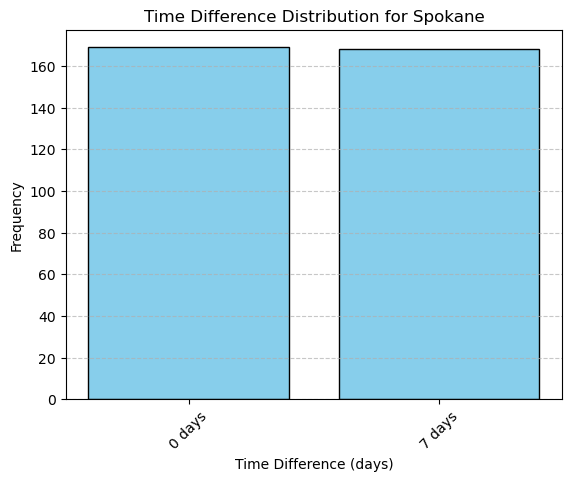

Time spacing counts for Charlotte:
Date
0 days    169
7 days    168
Name: count, dtype: int64



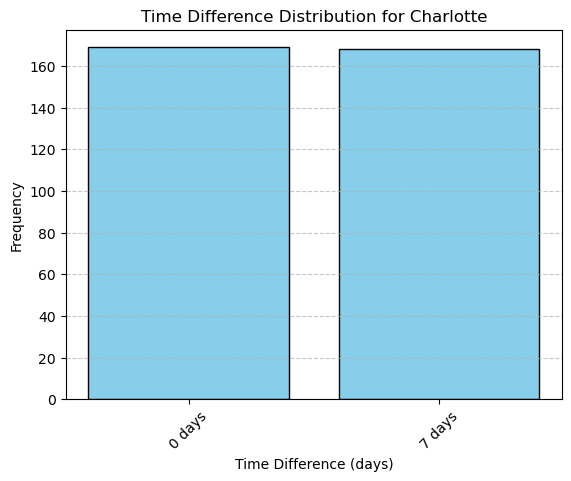

In [12]:
def plot_time_spacing_distribution(df, region):
    """
    Plots the distribution of time spacing for a given region.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with columns 'Location' and 'Date'.
        region (str): The region (e.g., location) to analyze.
    """
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Filter data for the given region
    region_data = df[df['region'] == region]
    
    if region_data.empty:
        print(f"No data available for region: {region}")
        return
    
    # Calculate time differences
    time_diffs = region_data['Date'].sort_values().diff().dropna()
    
    # Count the frequency of each time difference
    value_counts = time_diffs.value_counts().sort_index()
    
    # Display value counts
    print(f"Time spacing counts for {region}:\n{value_counts}\n")
    
    # Plot the bar chart
    plt.bar(value_counts.index.astype(str), value_counts.values, color='skyblue', edgecolor='black')
    plt.title(f"Time Difference Distribution for {region}")
    plt.xlabel("Time Difference (days)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


plot_time_spacing_distribution(df,'SanDiego')
plot_time_spacing_distribution(df,"Spokane")
plot_time_spacing_distribution(df,"Charlotte")

In [13]:
...

Ellipsis

In [14]:
...

Ellipsis

In [15]:
...

Ellipsis

In [16]:
...

Ellipsis

In [17]:
...

Ellipsis

In [18]:
...

Ellipsis

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.3 Interpreting regions 
rubric={points:4}

In the Rain in Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are also all distinct, or are there overlapping regions? Justify your answer by referencing the data.

<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 4

From the list of regions, it seems that some region names are specific cities, while others are broader geographical areas. For example:

City-specific regions: Albany, Atlanta, Boise, Chicago, Los Angeles, San Diego, etc.
Broad regions: California, GreatLakes, Midsouth, Northeast, West, TotalUS, etc.
Some of these broader regions may overlap with cities that fall within their larger geographical scope. For example, California might overlap with Los Angeles, San Francisco, and San Diego. Similarly, regions like Northeast might include cities like New York and Boston, and West could include cities like San Francisco and Los Angeles.

While the dataset contains distinct names for both cities and broader regions, there are likely overlapping regions where certain cities are part of larger regional groups (e.g., Los Angeles in California). Thus, the regions are not completely distinct in all cases, and some regions might overlap in terms of geographical coverage.

In [19]:
unique_regions = df['region'].unique()

unique_regions

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

In [20]:
...

Ellipsis

In [21]:
...

Ellipsis

<!-- END QUESTION -->

<br><br>

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We will be trying to forecast the avocado price. The function below is adapted from [Lecture 19](https://github.com/UBC-CS/cpsc330-2023W1/tree/main/lectures), with some improvements.

In [22]:
def create_lag_feature(df, orig_feature, lag, groupby, new_feature_name=None, clip=False):
    """
    Creates a new feature that's a lagged version of an existing one.
    
    NOTE: assumes df is already sorted by the time columns and has unique indices.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature
    
    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.
        
    """
        
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)
    
    new_df = df.assign(**{new_feature_name : np.nan})
    for name, group in new_df.groupby(groupby):        
        if lag < 0: # take values from the past
            new_df.loc[group.index[-lag:],new_feature_name] = group.iloc[:lag][orig_feature].values
        else:       # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][orig_feature].values
            
    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])
        
    return new_df

We first sort our dataframe properly:

In [23]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

Date  AveragePrice  Total Volume     4046      4225    4770  \
0     2015-01-04          1.22      40873.28  2819.50  28287.42   49.90   
1     2015-01-11          1.24      41195.08  1002.85  31640.34  127.12   
2     2015-01-18          1.17      44511.28   914.14  31540.32  135.77   
3     2015-01-25          1.06      45147.50   941.38  33196.16  164.14   
4     2015-02-01          0.99      70873.60  1353.90  60017.20  179.32   
...          ...           ...           ...      ...       ...     ...   
18244 2018-02-25          1.57      18421.24  1974.26   2482.65    0.00   
18245 2018-03-04          1.54      17393.30  1832.24   1905.57    0.00   
18246 2018-03-11          1.56      22128.42  2162.67   3194.25    8.93   
18247 2018-03-18          1.56      15896.38  2055.35   1499.55    0.00   
18248 2018-03-25          1.62      15303.40  2325.30   2171.66    0.00   

       Total Bags  Small Bags  Large Bags  XLarge Bags          type  year  \
0         9716.46     9186.93      529.53          0.0  conventional  2015   
1         8424.77     8036.04      388.73          0.0  conventional  2015   
2        11921.05    11651.09      269.96          0.0  conventional  2015   
3        10845.82    10103.35      742.47          0.0  conventional  2015   
4         9323.18     9170.82      152.36          0.0  conventional  2015   
...           ...         ...         ...          ...           ...   ...   
18244    13964.33    13698.27      266.06          0.0       organic  2018   
18245    13655.49    13401.93      253.56          0.0       organic  2018   
18246    16762.57    16510.32      252.25          0.0       organic  2018   
18247    12341.48    12114.81      226.67          0.0       organic  2018   
18248    10806.44    10569.80      236.64          0.0       organic  2018   

                 region  
0                Albany  
1                Albany  
2                Albany  
3                Albany  
4                Albany  
...                 ...  
18244  WestTexNewMexico  
18245  WestTexNewMexico  
18246  WestTexNewMexico  
18247  WestTexNewMexico  
18248  WestTexNewMexico  

[18249 rows x 13 columns]

We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [24]:
df_hastarget = create_lag_feature(df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True)
df_hastarget

Date  AveragePrice  Total Volume     4046      4225    4770  \
0     2015-01-04          1.22      40873.28  2819.50  28287.42   49.90   
1     2015-01-11          1.24      41195.08  1002.85  31640.34  127.12   
2     2015-01-18          1.17      44511.28   914.14  31540.32  135.77   
3     2015-01-25          1.06      45147.50   941.38  33196.16  164.14   
4     2015-02-01          0.99      70873.60  1353.90  60017.20  179.32   
...          ...           ...           ...      ...       ...     ...   
18243 2018-02-18          1.56      17597.12  1892.05   1928.36    0.00   
18244 2018-02-25          1.57      18421.24  1974.26   2482.65    0.00   
18245 2018-03-04          1.54      17393.30  1832.24   1905.57    0.00   
18246 2018-03-11          1.56      22128.42  2162.67   3194.25    8.93   
18247 2018-03-18          1.56      15896.38  2055.35   1499.55    0.00   

       Total Bags  Small Bags  Large Bags  XLarge Bags          type  year  \
0         9716.46     9186.93      529.53          0.0  conventional  2015   
1         8424.77     8036.04      388.73          0.0  conventional  2015   
2        11921.05    11651.09      269.96          0.0  conventional  2015   
3        10845.82    10103.35      742.47          0.0  conventional  2015   
4         9323.18     9170.82      152.36          0.0  conventional  2015   
...           ...         ...         ...          ...           ...   ...   
18243    13776.71    13553.53      223.18          0.0       organic  2018   
18244    13964.33    13698.27      266.06          0.0       organic  2018   
18245    13655.49    13401.93      253.56          0.0       organic  2018   
18246    16762.57    16510.32      252.25          0.0       organic  2018   
18247    12341.48    12114.81      226.67          0.0       organic  2018   

                 region  AveragePriceNextWeek  
0                Albany                  1.24  
1                Albany                  1.17  
2                Albany                  1.06  
3                Albany                  0.99  
4                Albany                  0.99  
...                 ...                   ...  
18243  WestTexNewMexico                  1.57  
18244  WestTexNewMexico                  1.54  
18245  WestTexNewMexico                  1.56  
18246  WestTexNewMexico                  1.56  
18247  WestTexNewMexico                  1.62  

[18141 rows x 14 columns]

Our goal is to predict `AveragePriceNextWeek`. 

Let's split the data:

In [25]:
df_train = df_hastarget[df_hastarget["Date"] <= split_date]
df_test  = df_hastarget[df_hastarget["Date"] >  split_date]

<br><br>

<!-- BEGIN QUESTION -->

### 1.4 `AveragePrice` baseline 
rubric={points}

Soon we will want to build some models to forecast the average avocado price a week in advance. Before we start with any ML though, let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse that this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get on the train and test data?

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Points:_ 4

_Type your answer here, replacing this text._

In [26]:
from sklearn.metrics import r2_score

df_train['BaselinePrediction'] = df_train['AveragePrice']
df_test['BaselinePrediction'] = df_test['AveragePrice']

train_r2 = r2_score(df_train['AveragePriceNextWeek'], df_train['BaselinePrediction'])
test_r2 = r2_score(df_test['AveragePriceNextWeek'], df_test['BaselinePrediction'])

train_r2

/var/folders/p0/ddg_z7lj6j99wdv48qsy8l4w0000gn/T/ipykernel_73567/896454540.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['BaselinePrediction'] = df_train['AveragePrice']
/var/folders/p0/ddg_z7lj6j99wdv48qsy8l4w0000gn/T/ipykernel_73567/896454540.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['BaselinePrediction'] = df_test['AveragePrice']


0.8285800937261841

In [27]:
test_r2

0.7631780188583048

In [28]:
...

Ellipsis

In [29]:
...

Ellipsis

In [30]:
assert not train_r2 is None, "Are you using the correct variable name?"
assert not test_r2 is None, "Are you using the correct variable name?"
assert sha1(str(round(train_r2, 3)).encode('utf8')).hexdigest() == 'b1136fe2a8918904393ab6f40bfb3f38eac5fc39', "Your training score is not correct. Are you using the right features?"
assert sha1(str(round(test_r2, 3)).encode('utf8')).hexdigest() == 'cc24d9a9b567b491a56b42f7adc582f2eefa5907', "Your test score is not correct. Are you using the right features?"

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Forecasting average avocado price
rubric={points:10}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

Benchmark: you should be able to achieve $R^2$ of at least 0.79 on the test set. I got to 0.80, but not beyond that. Let me know if you do better!

Note: because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

<div class="alert alert-warning">

Solution_1.5
    
</div>

_Points:_ 10

The approach leverages Pipelines and ColumnTransformers to streamline the workflow, ensuring efficient preprocessing and model fitting by encapsulating feature scaling, one-hot encoding, and model training into a single, modular process. The feature engineering process includes encoding seasonal trends (using a Season feature), capturing weather-related effects (via a binary IsRainingMonth feature), and incorporating temporal dependencies through lag and rolling features (e.g., AveragePriceLag1 and RollingMean1). This allows the model to capture both seasonal fluctuations and time series trends. The inclusion of models like RandomForestRegressor, GradientBoostingRegressor, and XGBoost offers flexibility in capturing complex relationships, while SVR and LinearRegression provide benchmarks for simpler models. The use of GridSearchCV ensures optimal hyperparameter tuning via cross-validation, avoiding overfitting while selecting the best-performing configurations for each model. R² is used as the evaluation metric, providing a clear measure of how well each model explains the variance in avocado prices, helping to identify the most effective approach for forecasting future prices.

In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Feature Engineering: Encoding Date Features and Adding Custom Features
def map_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

def is_raining_month(month):
    return 1 if month in [6, 7, 8] else 0

# Assuming df_train and df_test are already loaded
df_train['Season'] = df_train['Month'].apply(map_to_season)
df_test['Season'] = df_test['Month'].apply(map_to_season)
df_train['IsRainingMonth'] = df_train['Month'].apply(is_raining_month)
df_test['IsRainingMonth'] = df_test['Month'].apply(is_raining_month)

# Add lag and rolling features
def create_lag_features(df):
    df['AveragePriceLag1'] = df['AveragePrice'].shift(1)
    df['AveragePriceLag2'] = df['AveragePrice'].shift(2)
    df['RollingMean1'] = df['AveragePrice'].rolling(window=1).mean()
    df['RollingMean2'] = df['AveragePrice'].rolling(window=2).mean()
    df['PriceChange'] = df['AveragePrice'].diff()
    df.dropna(inplace=True)
    return df

df_train = create_lag_features(df_train)
df_test = create_lag_features(df_test)

# Select the features
features = ['WeekOfYear', 'DayOfWeek', 'Month', 'Year', 'DayOfYear', 'AveragePriceLag1', 
            'AveragePriceLag2', 'RollingMean1', 'RollingMean2', 'PriceChange', 
            'IsRainingMonth', 'Season']

# Define the column transformer (one-hot encode categorical and scale numerical features)
numeric_features = ['WeekOfYear', 'DayOfWeek', 'Month', 'Year', 'DayOfYear', 'AveragePriceLag1', 
                    'AveragePriceLag2', 'RollingMean1', 'RollingMean2', 'PriceChange', 'IsRainingMonth']

categorical_features = ['Season']

# Column transformer for scaling numerical features and one-hot encoding categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Define the models and their hyperparameter grids for GridSearchCV
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'LinearRegression': LinearRegression()
}

param_grids = {
    'RandomForest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['auto', 'sqrt', 'log2']
    },
    'GradientBoosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 5]
    },
    'SVR': {
        'model__C': [0.1, 1, 10],
        'model__epsilon': [0.01, 0.1, 0.2],
        'model__kernel': ['linear', 'rbf']
    },
    'LinearRegression': {}  # No hyperparameters for linear regression
}

# Initialize a dictionary to store results
results = {}

# Perform GridSearchCV for each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # GridSearchCV
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grids.get(model_name, {}),
                               cv=3, n_jobs=-1, verbose=2, scoring='r2')
    grid_search.fit(df_train[features], df_train['AveragePriceNextWeek'])
    
    # Store best parameters and R^2 score
    best_model = grid_search.best_estimator_
    predictions = best_model.predict(df_test[features])
    r2 = r2_score(df_test['AveragePriceNextWeek'], predictions)
    results[model_name] = {
        'Best Parameters': grid_search.best_params_,
        'R^2 Score': r2
    }

# Print results for each model
for model_name, result in results.items():
    print(f"\n{model_name} - Best Parameters: {result['Best Parameters']}")
    print(f"R^2 on Test Data: {result['R^2 Score']}")


KeyError: 'Month'

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: Short answer questions

<!-- BEGIN QUESTION -->

### 2.1 Time series

rubric={points:6}

The following questions pertain to Lecture 20 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.
3. When studying time series modeling, we explored several ways to encode date information as a feature for the citibike dataset. When we used time of day as a numeric feature, the Ridge model was not able to capture the periodic pattern. Why? How did we tackle this problem? Briefly explain.

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 6

1. A real-world example of a time series with unequally spaced time points could be sensor data from a piece of industrial equipment. In this case, the sensors might record data at irregular intervals based on when a significant event occurs, such as a malfunction or a scheduled maintenance check. As a result, the timestamps may be unevenly distributed, reflecting varying levels of activity or data capture frequency.

2. Encoding the date as one or more features might struggle with unequally spaced time points. This is because this approach assumes that each time point is evenly spaced, and if the data points are irregularly spaced, the model may not properly capture the underlying temporal relationships or trends.
Creating lagged versions of features might also struggle with unequally spaced time points. Lag features are typically based on fixed time intervals (e.g., previous day's price or previous week's price). If the time intervals are irregular, the lagged features may not align correctly with the actual data, leading to inaccurate or misleading features.
Both methods assume that the time points are spaced regularly, and when time intervals vary, it becomes difficult for these approaches to appropriately capture the temporal dependencies. A more advanced method, like time series interpolation or time-aware models, would be more effective for handling this issue.

3. When we used time of day as a numeric feature in the Ridge regression model for the Citibike dataset, the model struggled to capture the periodic pattern because time of day is cyclic (i.e., the time "wraps around" at 24 hours, so the time of day at 23:00 is closer to the time at 00:00 than to 12:00). Treating time of day as a numeric feature in a linear fashion (e.g., 00:00 as 0, 12:00 as 12, and 23:00 as 23) does not account for this cyclical nature, making it difficult for the model to learn periodic patterns.

How we tackled this problem: To address this issue, we encoded time of day as two features: the sine and cosine transformations of the time. This method maps the time of day onto a circular scale, where sine captures the horizontal position on the circle and cosine captures the vertical position. By using both sine and cosine, the model can correctly interpret the periodic nature of the time of day, enabling it to better capture cyclical patterns, like bike usage during different hours of the day.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 Computer vision 
rubric={points:6}

The following questions pertain to Lecture 19 on multiclass classification and introduction to computer vision. 

1. How many parameters (coefficients and intercepts) will `sklearn`’s `LogisticRegression()` model learn for a four-class classification problem, assuming that you have 10 features? Briefly explain your answer.
2. In Lecture 19, we briefly discussed how neural networks are sort of like `sklearn`'s pipelines, in the sense that they involve multiple sequential transformations of the data, finally resulting in the prediction. Why was this property useful when it came to transfer learning?
3. Imagine that you have a small dataset with ~1000 images containing pictures and names of 50 different Computer Science faculty members from UBC. Your goal is to develop a reasonably accurate multi-class classification model for this task. Describe which model/technique you would use and briefly justify your choice in one to three sentences.

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 6

1. For multinomial logistic regression (which is the typical type used for multiclass problems in sklearn), the model learns a set of coefficients for each class (except one, which is treated as the reference class). For each of the 4 classes, the model learns 10 coefficients (one for each feature), plus 1 intercept. This means:
For 4 classes: 3 sets of coefficients (since one class is used as a reference class) with 10 coefficients each.
Plus 3 intercepts (since one intercept is used for the reference class).
Thus, the total number of parameters is 33

2. Neural networks can be thought of as sequential transformations of data because they involve multiple layers, each performing a transformation on the input data. These transformations can include activation functions, convolutions, or pooling, which allow the model to learn increasingly abstract representations of the input data. This property is particularly useful for transfer learning, where the lower layers (which capture general features like edges, textures, etc.) can be reused across different tasks. Instead of starting from scratch, you can fine-tune the higher layers (task-specific) while keeping the lower layers fixed, allowing the model to learn from the pre-trained representations of data on a larger dataset and apply them to the smaller dataset at hand.

3. For a small dataset like this, a Convolutional Neural Network (CNN) would be a good choice. CNNs are highly effective for image classification tasks because they can automatically learn spatial hierarchies of features, such as edges, shapes, and textures, which are important for identifying objects in images. Given the relatively small size of the dataset (~1000 images), you might consider transfer learning using a pre-trained CNN model (such as ResNet, VGG, or MobileNet) and fine-tuning it for your specific task. This approach leverages the knowledge learned from large datasets (like ImageNet), helping to improve performance on the smaller dataset by avoiding overfitting and reducing the need for a large amount of labeled data.

<!-- END QUESTION -->

<br><br>

**Before submitting your assignment, please make sure you have followed all the instructions in the Submission instructions section at the top.** 

![](img/eva-well-done.png)